# Анализ и сегментация пользователей регионального банка

**Цель исследования**<br>
Проанализировать клиентов регионального банка и сегментировать их по количеству потребляемых продуктов.

**Этапы исследования**:
1. Изучение и предобработка данных
2. Исследовательский анализ данных
3. Сегментация клиентов
4. Кластеризация (методом дендрограммы и K-means)
5. Статистические гипотезы и их проверка

## Материалы

* Презентация (https://disk.yandex.ru/i/8eq_UiDuxpJcpg)
* Дашборд (https://public.tableau.com/views/Finalproject_16590761606690/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

import itertools
import warnings
warnings.filterwarnings('ignore')

## Изучение исходных данных

In [2]:
bank = pd.read_csv('/datasets/bank_dataset.csv')
display(bank.head())

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [3]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


**Таблица состоит из 12 столбцов и 10000 строк с разными типами значений.**

**Количественные переменные:**
* user_id
* score
* Age
* Objects
* Products

**Булевы переменные:**
* CreditCard
* Loyalty
* Churn
    
**Вещественные переменные:**
* Balance
* estimated_salary

**Категориальные данные:**
* City (неупорядоченные)
* Gender (упорядоченные)

In [4]:
#проверяю дубликаты
print('Общее число дубликатов:', bank.duplicated().sum())

#проверяю пропуски
print('Общее число пропущенных значений:', bank.isna().sum())

Общее число дубликатов: 0
Общее число пропущенных значений: userid                 0
score                  0
City                   0
Gender                 0
Age                    0
Objects                0
Balance             3617
Products               0
CreditCard             0
Loyalty                0
estimated_salary       0
Churn                  0
dtype: int64


Явных дубликатов не обнаружено. Пропуски данных имеются только в строке Balance.

## Предобработка данных

In [5]:
#переименуем ряд заголовков: сделаем написание строчными буквами
bank.columns = map(str.lower, bank.columns)
#изменим написание некоторых заголовков
bank.rename(columns = {'userid' : 'user_id', 'creditcard' : 'credit_card'}, inplace = True)
display(bank.head())

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [6]:
#значение user_id установим в качестве индекса dataframe
bank = bank.set_index('user_id')

In [7]:
#посмотреть уникальные значения по некоторым столбцам
print('Значения в city:', bank['city'].sort_values().unique())
print('Значения в score:', bank['score'].sort_values().unique())
print('Значения в age:', bank['age'].sort_values().unique())
print('Значения в objects:', bank['objects'].sort_values().unique())
print('Значения в products:', bank['products'].unique())
print('Значения в credit_card:', bank['credit_card'].sort_values().unique())

Значения в city: ['Ростов Великий' 'Рыбинск' 'Ярославль']
Значения в score: [350 351 358 359 363 365 367 373 376 382 383 386 395 399 401 404 405 407
 408 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444
 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462
 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534
 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552
 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570
 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588
 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606
 607 608 609 610 611 612 613 614 615 616 617 618

Всего в данных содержится информация о клиентах **3 городов**.<br>
**Кредитный рейтинг** варьируется от 350 до 850 баллов.<br>
**Возраст** клиентов от 18 до 92 лет.<br>
Количество **обьектов в собственности** от 0 до 10.<br>
Количество **банковских продуктов** у клиента может быть от 1 до 4.<br>
**Кредитная карта** у клиента может быть, а может и не быть.<br>

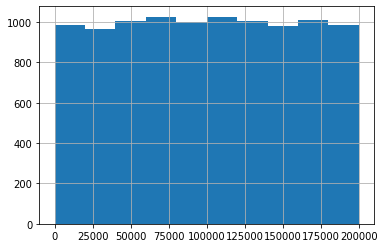

In [8]:
bank['estimated_salary'].hist()
plt.show()

Разделим клиентов на 3 разных варианта зарплат:
- до 50000
- от 50000 до 150000
- от 150000 и больше

Создадим еще один столбец и присвоим ему разную категорию в зависимости от зп:
- низкая
- средняя 
- высокая

In [9]:
#создание функции для отнесения в определенную группу в зависимости от зарплаты
def salary(data):
    if data < 50000:
        return 'низкая'
    if (data  > 150000):
        return 'высокая'
    else:
        return 'средняя'
#проверка
print(salary(35000))
print(salary(75000))
print(salary(135000))
print(salary(180000))

низкая
средняя
средняя
высокая


In [10]:
#добавление нового столбца с группой по уровню зп
bank['salary_level'] = bank['estimated_salary'].apply(salary)
display(bank.head(5))

,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,salary_level
user_id,,,,,,,,,,,,
15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,средняя
15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,средняя
15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,средняя
15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,средняя
15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,средняя


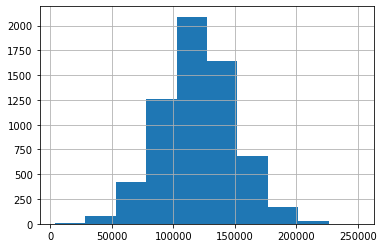

In [11]:
bank['balance'].hist()
plt.show()

Можем разбить остатки по счетам клиентов на следующие интервалы:
- 0-49000,
- 49000-75000,
- 75000-125000,
- 125000-165000,
- 165000 и больше<br>
Создадим дополнительный столбец с этими категориями

In [12]:
#создание функции для отнесения в определенную группу в зависимости от баланса
def balance(data):
    if data < 49000:
        return 'меньше 49000'
    if (data>49000)&(data<75000):
        return '49000-75000'
    if (data > 75000)& (data < 125000):
        return '75000-125000'
    if (data > 125000)& (data < 165000):
        return '125000-165000'
    else:
        return '165000 и больше'
#проверка
print(balance(35000))
print(balance(75000))
print(balance(135000))
print(balance(180000))

меньше 49000
165000 и больше
125000-165000
165000 и больше


In [13]:
#добавление нового столбца с группой по уровню баланса
bank['balance_range'] = bank['balance'].apply(balance)
display(bank.head(5))

,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,salary_level,balance_range
user_id,,,,,,,,,,,,,
15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,средняя,165000 и больше
15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,средняя,75000-125000
15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,средняя,125000-165000
15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,средняя,165000 и больше
15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,средняя,125000-165000


In [14]:
#применим метод get_dummies для преобразования города и пола в числовой код
bank_new = pd.get_dummies(bank)
display(bank_new.head())

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов Великий,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
user_id,,,,,,,,,,,,,,,,,,,,,
15677338,619,42,2,NaN,1,1,1,101348.88,1,0,...,1,0,0,0,1,0,1,0,0,0
15690047,608,41,1,83807.86,1,0,1,112542.58,0,0,...,1,0,0,0,1,0,0,0,1,0
15662040,502,42,8,159660.80,3,1,0,113931.57,1,0,...,1,0,0,0,1,1,0,0,0,0
15744090,699,39,1,NaN,2,0,0,93826.63,0,0,...,1,0,0,0,1,0,1,0,0,0
15780624,850,43,2,125510.82,1,1,1,79084.10,0,0,...,1,0,0,0,1,1,0,0,0,0


In [15]:
bank_new.rename(columns = {'city_Ростов Великий' : 'city_Ростов'}, inplace = True)
display(bank_new.head())

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
user_id,,,,,,,,,,,,,,,,,,,,,
15677338,619,42,2,NaN,1,1,1,101348.88,1,0,...,1,0,0,0,1,0,1,0,0,0
15690047,608,41,1,83807.86,1,0,1,112542.58,0,0,...,1,0,0,0,1,0,0,0,1,0
15662040,502,42,8,159660.80,3,1,0,113931.57,1,0,...,1,0,0,0,1,1,0,0,0,0
15744090,699,39,1,NaN,2,0,0,93826.63,0,0,...,1,0,0,0,1,0,1,0,0,0
15780624,850,43,2,125510.82,1,1,1,79084.10,0,0,...,1,0,0,0,1,1,0,0,0,0


In [16]:
bank_balance_0 = bank[bank['balance'].isna()]
display(bank_balance_0.tail())
bank_balance_0.info()
#посмотреть уникальные значения по некоторым столбцам
print('Значения в city:', bank_balance_0['city'].sort_values().unique())

,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,salary_level,balance_range
user_id,,,,,,,,,,,,,
15648358,841,Рыбинск,М,28,4,NaN,2,1,1,179436.60,0,высокая,165000 и больше
15699841,726,Рыбинск,М,36,2,NaN,1,1,0,195192.40,0,высокая,165000 и больше
15762030,800,Ярославль,Ж,29,2,NaN,2,0,0,167773.55,0,высокая,165000 и больше
15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0,средняя,165000 и больше
15627268,709,Ярославль,Ж,36,7,NaN,1,0,1,42085.58,1,низкая,165000 и больше


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3617 entries, 15677338 to 15627268
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   score             3617 non-null   int64  
 1   city              3617 non-null   object 
 2   gender            3617 non-null   object 
 3   age               3617 non-null   int64  
 4   objects           3617 non-null   int64  
 5   balance           0 non-null      float64
 6   products          3617 non-null   int64  
 7   credit_card       3617 non-null   int64  
 8   loyalty           3617 non-null   int64  
 9   estimated_salary  3617 non-null   float64
 10  churn             3617 non-null   int64  
 11  salary_level      3617 non-null   object 
 12  balance_range     3617 non-null   object 
dtypes: float64(2), int64(7), object(4)
memory usage: 395.6+ KB
Значения в city: ['Рыбинск' 'Ярославль']


Пропущены значения баланса для клиентов, которые проживают исключительно в Рыбинске и Ярославле. Возможно, техническая проблема, потому что другие закономерности неочевидны. <br>
Пропусков данных достаточно много, чтобы их удалить без последствий для dataset. Если заменить на 0, то сильно сдвинутся средние. Поэтому на текущий момент я хочу оставить их без изменений.

## Исследовательский анализ данных (EDA)

### Первичная оценка параметров данных

In [17]:
#применим метод describe для первичной оценки параметров
bank_new.describe()

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
count,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,...,0.454300,0.545700,0.245500,0.245300,0.50920,0.228500,0.406300,0.035400,0.32280,0.007000
std,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,...,0.497932,0.497932,0.430405,0.430286,0.49994,0.419887,0.491166,0.184798,0.46757,0.083377
min,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,1.00000,0.000000,1.000000,0.000000,1.00000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000


**city:**
- 25% клиентов проживают в Ростове Великом
- около 25% - в Рыбинске
- 50% клиентов живут в Ярославле

**gender:**
- около 45% клиентов женского пола
- около 55% - мужского пола

**score:**
- среднее значение кредитного рейтинга составляет 650, медиана - 652. Соответственно, значительных выбросов нет.
- минимум - 350, максимум - 850.

**age:**
- средний возраст клиента составляет почти 39 лет, а медианный - 37 лет. Также можно отметить отсутствие значительных выбросов.

**objects:**
- среднее и медианное количество объектов в собственности у клиента составляет 5 штук

**balance:**
- среднее значение баланса на счете у клиента составляет 119 827 единиц, медианное значение - 119 839 единиц. Отсутствие значительного количества выбросов. 
- минимум - 3769 единиц, максимум - 250 898 единиц.

**products:**
- у 50% клиентов всего один продукт.
- при этом среднее значение - 1,53 продукта. 
- всего 25% клиентов имеют 2 продукта банка и более, при этом максимальное число - 4 штуки.

**credit_cards:**
- у 70% клиентов есть кредитная карта.

**loyalty:**
- только 51,5% клиентов являются активными пользователями услуг банка.

**estimated_salary:**
- средняя и медианная зарплата клиентов примерно совпадает и составляет около 100 000. 
- 25% клиентов имеют зарплату 51 000 и менее, а другие 25% - почти 150 000 и более.

**churn:**
- уровень оттока клиентов составляет 20%.

### Средние, медианные значения, мода и распределение признаков в группе оставшихся клиентов и в группе ушедших

In [18]:
# посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
display(bank_new.groupby(['churn']).mean())

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,city_Ростов,city_Рыбинск,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
churn,,,,,,,,,,,,,,,,,,,,,
0,651.853196,37.408389,5.033279,119535.864270,1.544267,0.707146,0.554565,99738.391772,0.212859,0.259199,...,0.427477,0.572523,0.242120,0.246641,0.511239,0.219515,0.432877,0.034911,0.307045,0.005651
1,645.351497,44.837997,4.932744,120746.971132,1.475209,0.699067,0.360825,101465.677531,0.399607,0.202749,...,0.559156,0.440844,0.258714,0.240059,0.501227,0.263623,0.302405,0.037310,0.384389,0.012273


In [19]:
# посмотрим на медианные значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
display(bank_new.groupby(['churn']).median())

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,city_Ростов,city_Рыбинск,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
churn,,,,,,,,,,,,,,,,,,,,,
0,653,36,5,119791.215,2,1,1,99645.04,0,0,...,0,1,0,0,1,0,0,0,0,0
1,646,45,5,119948.090,1,1,0,102460.84,0,0,...,1,0,0,0,1,0,0,0,0,0


In [20]:
# посмотрим на моды признаков в двух группах — тех, кто ушел в отток и тех, кто остался
display(bank_new.mode())

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
0,850.0,37.0,2.0,105473.74,1.0,1.0,1.0,24924.92,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,130170.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Исходя из средних значений числовых характеристик можно отметить следующие закономерности, которые мы наблюдаем у 'отточных' клиентов:
- более зрелые (средний возраст почти 45 лет против 37 лет у тех, кто остается)
- менее активно пользуются услугами банка (36% активных пользователей против 55% среди тех, кто остается)
- чаще проживают в городе Ростов Великий
- чаще женского пола

<div><b></b>
Исходя из медианных значений числовых характеристик можно отметить следующие закономерности у 'отточных' клиентов:<br>
- более зрелые (средний возраст почти 45 лет против 36 лет у тех, кто остается)<br>
- чаще женского пола<br>
- более высокая зарплата<br>
- чаще 1 продукт банка<br>
- нет текущей активности по продуктам<br>

У тех клиентов, которые остаются:<br>
- ниже зарплата (99 000 против 102 000)<br>
- чаще мужчины<br>
- чаще проживают в Ярославле<br>
- чаще мужского пола<br>
- чаще имеют текущую активность по продуктам<br>
- имеют 2 продукта банка

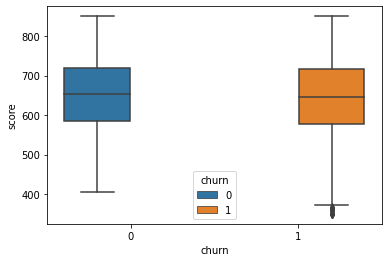

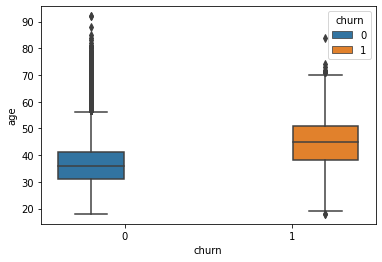

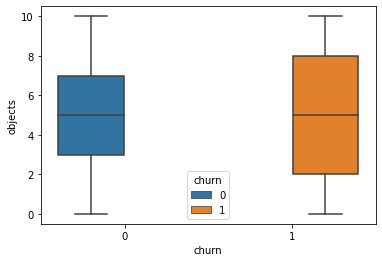

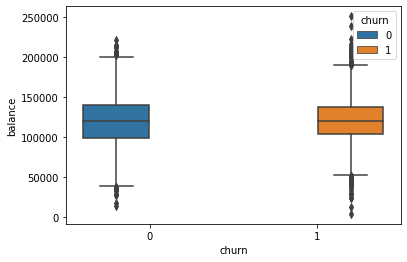

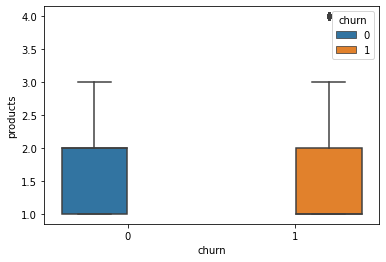

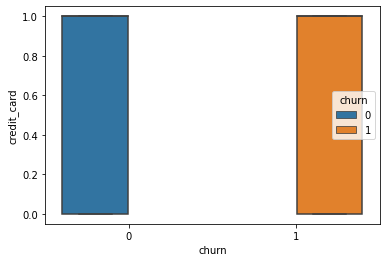

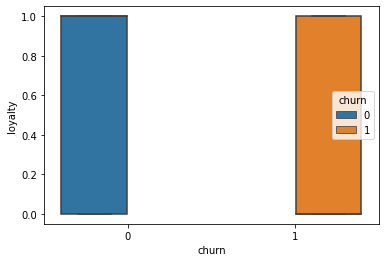

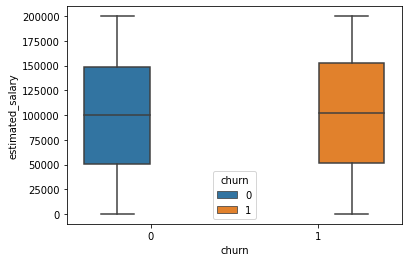

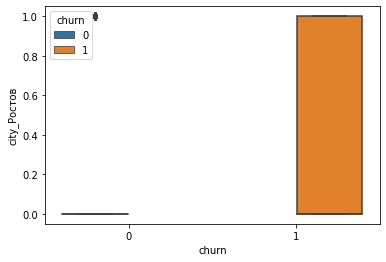

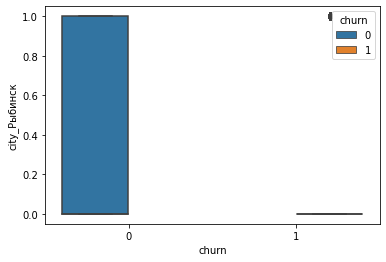

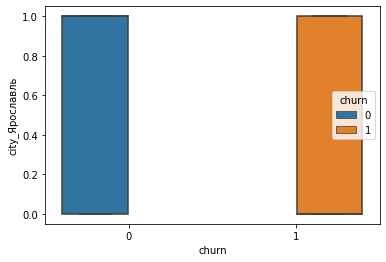

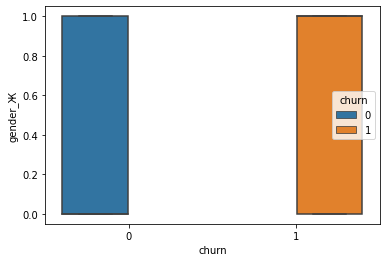

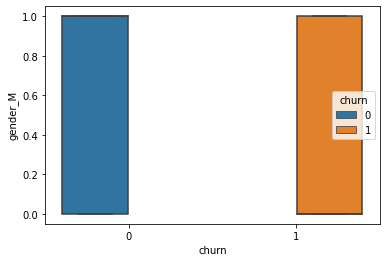

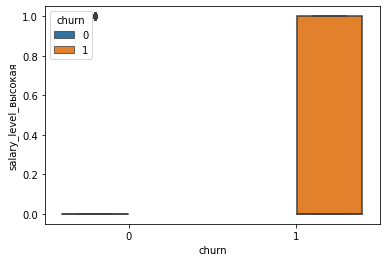

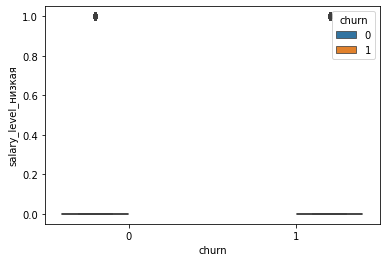

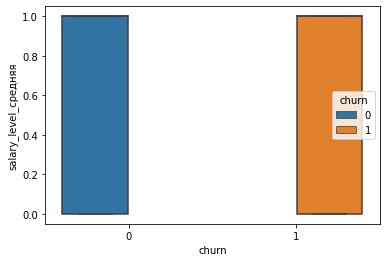

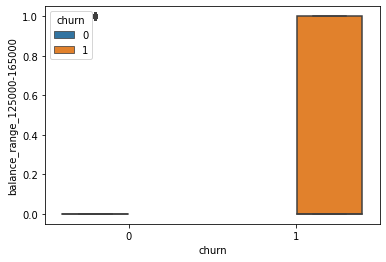

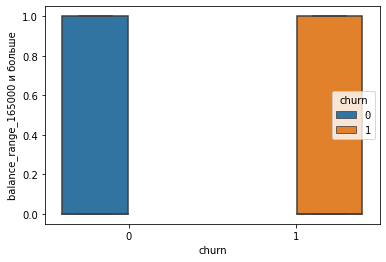

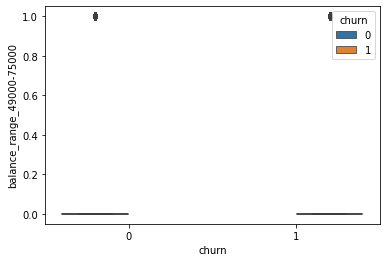

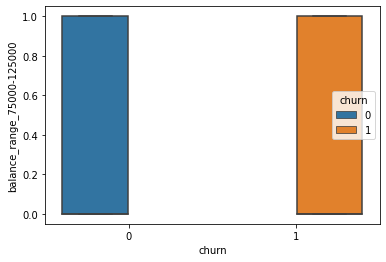

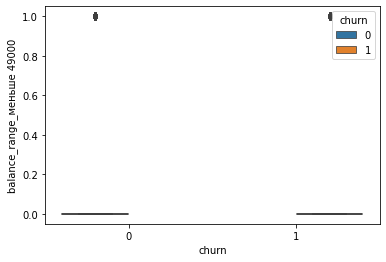

In [22]:
#построим попарные боксплоты для каждого признака
for col in bank_new.drop('churn', axis = 1).columns:
    sns.boxplot(data=bank_new, x="churn", y=col, hue = 'churn')#ваш код здесь
    plt.show()

### Матрица корреляций признаков

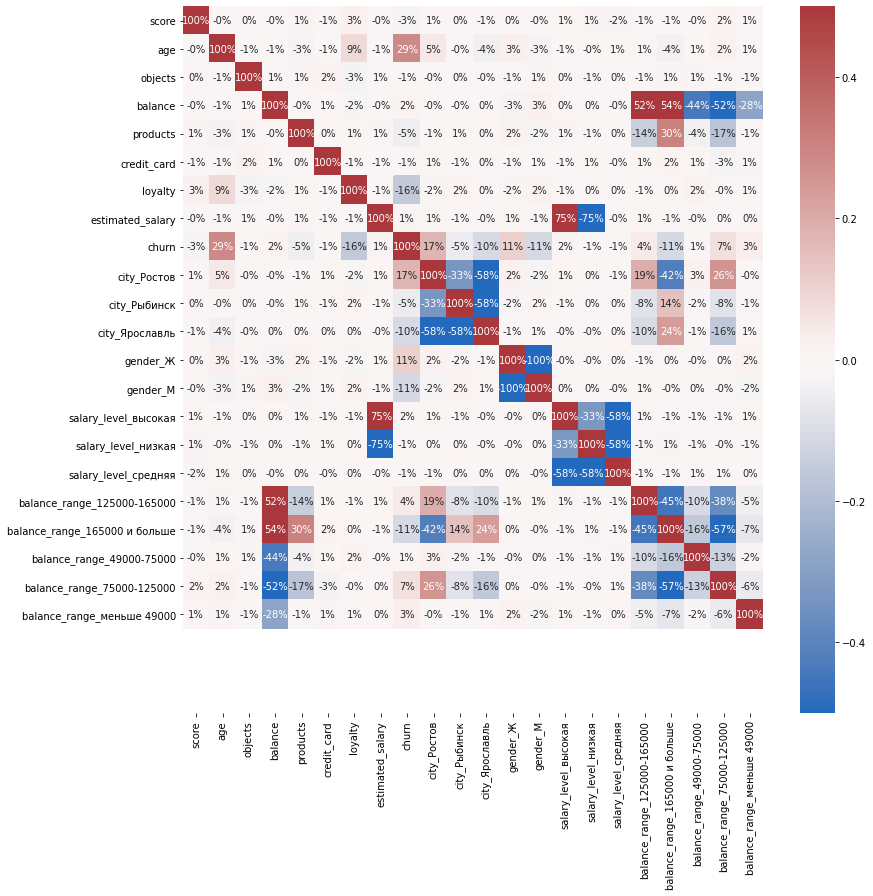

In [23]:
cm = bank_new.corr()
fig, ax = plt.subplots(figsize = (13, 13))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, fmt=".0%", cmap="vlag", vmin=-0.5, vmax=0.5)
sns.color_palette()
ax.set_ylim(
   25, 0
)  # корректировка "рваных" полей heatmap в последней версии библиотеки
plt.show()

Матрица корреляций подтверждает ранее сделанные выводы: наибольшая положительная зависимость с churn у города Ростов Великий, полом (преимущественно женщины), возрастом. Отрицательная корреляция - лояльность (т.е. использование продуктов банка в текущий момент).

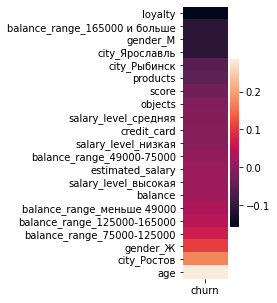

In [26]:
#выделим корреляцию только для churn
plt.figure(figsize=(1, 5))
sns.heatmap(
    cm.loc[:,['churn']].drop('churn').sort_values('churn'), fmt=".0%")
ax.set_ylim(
   125, 0
)
plt.tight_layout()
plt.show()

## Графики распределения оттока клиентов в зависимости от различных параметров

### Динамика оттока клиентов в зависимости от возраста

In [27]:
#по абсолютным значениям
bank_pivot_total = pd.pivot_table(bank_new, index = 'age', values = {'churn'}, aggfunc = {'sum','count'})
bank_pivot_total.columns = [tup[1] if tup[1] else tup[0] for tup in bank_pivot_total.columns]
bank_pivot_total.rename(columns = {'sum' : 'qnt_churn', 'count' : 'qnt_total'}, inplace = True)
display(bank_pivot_total.head())

,qnt_total,qnt_churn
age,,
18,22,2
19,27,1
20,40,2
21,53,3
22,84,12


<AxesSubplot:xlabel='age'>

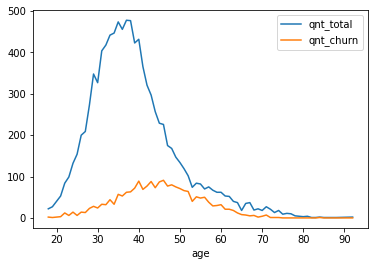

In [28]:
bank_pivot_total.plot()

In [29]:
#по относительным значениям
bank_pivot_total['churn_%']=((bank_pivot_total['qnt_churn'])/(bank_pivot_total['qnt_churn'].sum())*100).round(2)
bank_pivot_total['total_%']=((bank_pivot_total['qnt_total'])/(bank_pivot_total['qnt_total'].sum())*100).round(2)
display(bank_pivot_total.tail())

,qnt_total,qnt_churn,churn_%,total_%
age,,,,
83,1,0,0.00,0.01
84,2,1,0.05,0.02
85,1,0,0.00,0.01
88,1,0,0.00,0.01
92,2,0,0.00,0.02


<AxesSubplot:xlabel='age'>

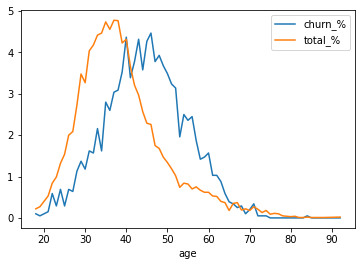

In [30]:
bank_pivot_total[{'churn_%','total_%'}].plot()

Исходя из графика возраста клиентов по общей выборке и выборке клиентов, которые ушли в отток, можно разбить из на 3 группы:
- от 18 до чуть меньше 40 лет (предположим, 38), когда отток % соотношение клиентов этого возраста, которые ушли из банка, ниже, чем доля клиентов, которые остались
- от 38 до 65, при котором уходящих клиентов этого возраста в % соотношении, больше оставшихся
- от 65 лет, когда опять соотношение в целом меняентся

### Динамика оттока клиентов в зависимости от количества продуктов

In [32]:
#по абсолютным значениями 
bank_pivot_product = pd.pivot_table(bank_new, index = 'products', values = {'churn'}, aggfunc = {'sum','count'})
bank_pivot_product.rename(columns = {'sum' : 'qnt_churn', 'count' : 'qnt_total'}, inplace = True)
display(bank_pivot_product.head())

churn          
         qnt_total qnt_churn
products                    
1             5084      1409
2             4590       348
3              266       220
4               60        60

<AxesSubplot:xlabel='products'>

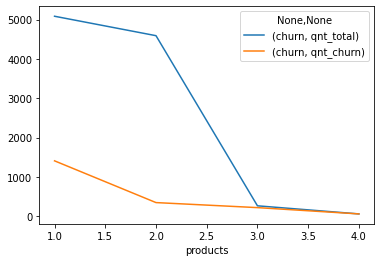

In [33]:
bank_pivot_product.plot()

По графику выше видно, что если количество продуктов у клиента составляет 3 или 4 штуки: то уровень ухода таких клиентов выше, чем клиентов, у которых продуктов 1 или 2, причем максимальный разрыв достигается при 2 продуктах.

### Динамика оттока клиентов в зависимости от диапазона зарплат

In [34]:
#по абсолютным значениям
bank_pivot_salary = pd.pivot_table(bank, index = 'salary_level', values = {'churn'}, aggfunc = {'sum','count'})
bank_pivot_salary.columns = [tup[1] if tup[1] else tup[0] for tup in bank_pivot_salary.columns]
bank_pivot_salary.rename(columns = {'sum' : 'qnt_churn', 'count' : 'qnt_total'}, inplace = True)
display(bank_pivot_salary.head())

,qnt_total,qnt_churn
salary_level,,
высокая,2455,527
низкая,2453,489
средняя,5092,1021


<AxesSubplot:xlabel='salary_level'>

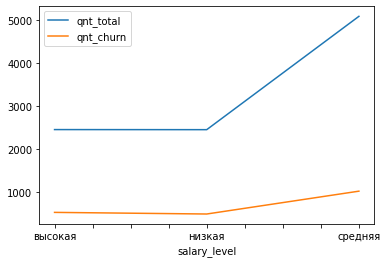

In [35]:
bank_pivot_salary.plot()

,qnt_total,qnt_churn,churn_%,total_%
salary_level,,,,
высокая,2455,527,25.87,24.55
низкая,2453,489,24.01,24.53
средняя,5092,1021,50.12,50.92


<AxesSubplot:xlabel='salary_level'>

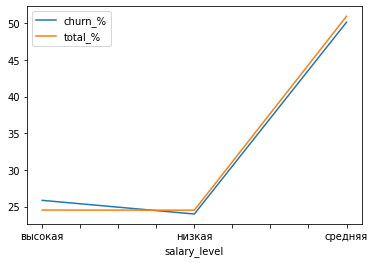

In [36]:
#по относительным значениям
bank_pivot_salary['churn_%']=((bank_pivot_salary['qnt_churn'])/(bank_pivot_salary['qnt_churn'].sum())*100).round(2)
bank_pivot_salary['total_%']=((bank_pivot_salary['qnt_total'])/(bank_pivot_salary['qnt_total'].sum())*100).round(2)
display(bank_pivot_salary.tail())
bank_pivot_salary[{'churn_%','total_%'}].plot()

Из графика относительной величины общего количества клиентов и отточных клиентов видно, что клиенты с более высоким доходом менее лояльны банку

,qnt_total,qnt_churn
balance_range,,
125000-165000,2285,537
165000 и больше,4063,616
49000-75000,354,76
75000-125000,3228,783
меньше 49000,70,25


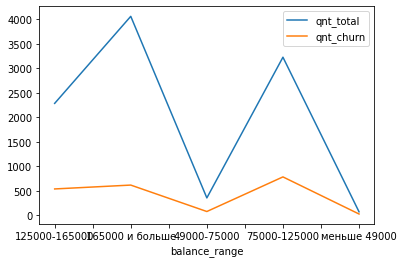

In [37]:
#по абсолютным значениям
bank_pivot_balance = pd.pivot_table(bank, index = 'balance_range', values = {'churn'}, aggfunc = {'sum','count'})
bank_pivot_balance.columns = [tup[1] if tup[1] else tup[0] for tup in bank_pivot_balance.columns]
bank_pivot_balance.rename(columns = {'sum' : 'qnt_churn', 'count' : 'qnt_total'}, inplace = True)
display(bank_pivot_balance.head())
bank_pivot_balance.plot()
plt.show()

### Динамика оттока клиентов в зависимости от баланса на счетах

,qnt_total,qnt_churn,churn_%,total_%
balance_range,,,,
125000-165000,2285,537,26.36,22.85
165000 и больше,4063,616,30.24,40.63
49000-75000,354,76,3.73,3.54
75000-125000,3228,783,38.44,32.28
меньше 49000,70,25,1.23,0.70


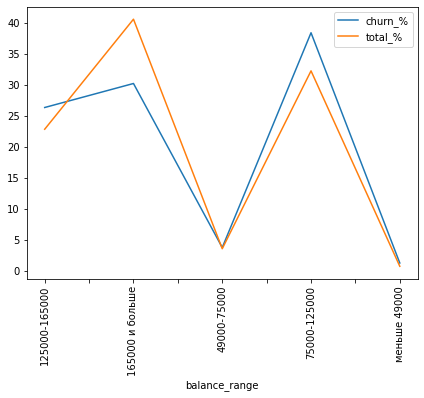

In [38]:
#по относительным значениям

bank_pivot_balance['churn_%']=((bank_pivot_balance['qnt_churn'])/(bank_pivot_balance['qnt_churn'].sum())*100).round(2)
bank_pivot_balance['total_%']=((bank_pivot_balance['qnt_total'])/(bank_pivot_balance['qnt_total'].sum())*100).round(2)
display(bank_pivot_balance.tail())
bank_pivot_balance[{'churn_%','total_%'}].plot(figsize=(7, 5))
plt.xticks(rotation=90)
plt.show()

Исходя из графика можно сделать выводы о высоком оттоке у клиентов со следующими диапазонами денежных средств на балансах:
- 75000-125000
- 125000-165000

Почти равные при балансе от 0 до 75000

Низкий уровень оттока у клиентов с балансом 
- 165 и больше

## Предварительные выводы по исследовательскому анализу данных

Исходя из проведенного анализа данных и матрицы корреляций наибольший вес при решении уйти в банке будут иметь:
- Возраст - чаще в отток уходят клиенты в возрасте старше 38 лет
- Город проживания - чаще в отток уходят жители Ростова Великого
- Пол - уйти больше склонны женщины
- Баланс по счетам - склонны уходить с балансом от 75000 до 165000 Руб. Но, скорее всего, тут влияют другие факторы, потому что диапазон от 75000 до 125000 - это самая многочисленная группа
- Уровень зарплаты - более склонны уходить клиенты с зарплатой в диапазоне от 145000 Руб.
- Количество продуктов - при 1-2 продуктов клиенты максимально лояльны, при 3-4 уходят

## Сегментация пользователей

### Дерево принятия решений

In [39]:
#удалим столбец с балансом, в котором содержаться NAN
bank_no_balance = bank_new.drop(columns = ['balance'],axis = 1)
#data['total_income'] = data['total_income'].fillna(data.groupby('income_type')['total_income'].transform('median'))

#проверка
display(bank_no_balance.head())

,score,age,objects,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,city_Рыбинск,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
user_id,,,,,,,,,,,,,,,,,,,,,
15677338,619,42,2,1,1,1,101348.88,1,0,0,...,1,0,0,0,1,0,1,0,0,0
15690047,608,41,1,1,0,1,112542.58,0,0,1,...,1,0,0,0,1,0,0,0,1,0
15662040,502,42,8,3,1,0,113931.57,1,0,0,...,1,0,0,0,1,1,0,0,0,0
15744090,699,39,1,2,0,0,93826.63,0,0,0,...,1,0,0,0,1,0,1,0,0,0
15780624,850,43,2,1,1,1,79084.10,0,0,1,...,1,0,0,0,1,1,0,0,0,0


In [40]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = bank_no_balance.drop('churn', axis=1)
y = bank_no_balance['churn']

In [41]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [42]:
# зададим алгоритм для новой модели на основе алгоритма решающего дерева
tree_model = DecisionTreeClassifier(min_samples_leaf=50, random_state=0, max_depth = 3)

tree_model.fit(X_train_st, y_train)# обучите модель

DecisionTreeClassifier(max_depth=3, min_samples_leaf=50, random_state=0)

In [43]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
tree_predictions = tree_model.predict(X_test_st)
tree_probabilities = tree_model.predict_proba(X_test_st)[:, 1]

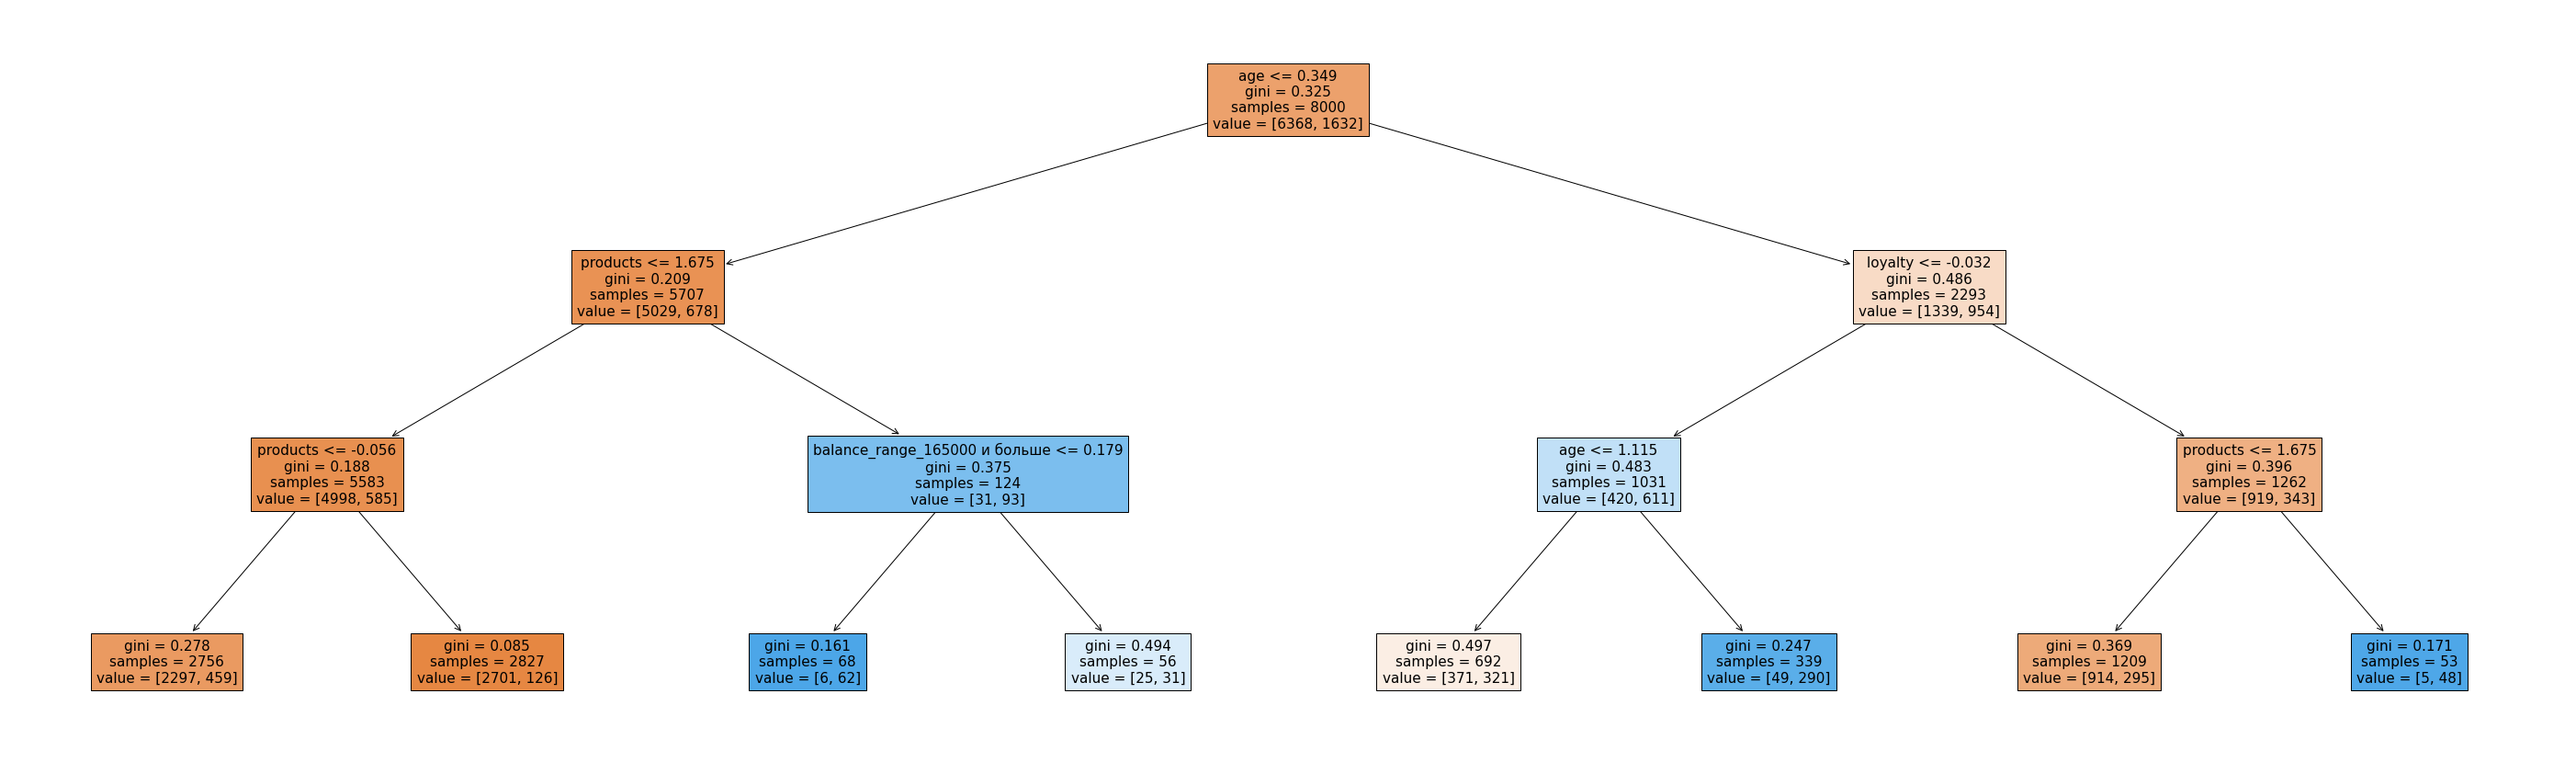

In [44]:
plt.figure(figsize = (50,15)) # задайте размер фигуры, чтобы получить крупное изображение
tree.plot_tree(tree_model, filled=True, feature_names = X_train.columns)
plt.show()

In [45]:
# перевод масштабированных значений в реальные
fic_list = [0,0.349,0,0.675,1.924,-0.032,-0.025] 
fiction_X_st = pd.Series(fic_list + [0] * (X.shape[1] - len(fic_list)), index=X.columns)
fiction_X_st_nonzero = fiction_X_st[fiction_X_st != 0]
print("Масштабированные значения")
print(fiction_X_st_nonzero)
print("\nРеальные значения",end="")
fiction_X = pd.Series(scaler.inverse_transform(fiction_X_st), index=X.columns)
display(fiction_X[fiction_X_st_nonzero.index])

Масштабированные значения
age                 0.349
products            0.675
credit_card         1.924
loyalty            -0.032
estimated_salary   -0.025
dtype: float64

Реальные значения

age                    42.501278
products                1.922302
credit_card             1.582779
loyalty                 0.499883
estimated_salary    98733.911979
dtype: float64

**Последовательность проверки клиентов на возможность уйти:** <br>
<br>
Возраст клиента меньше или равен 42 года.<br>
<br>
**Если да**, то следующий вопрос касается количества продуктов: меньше 2 или больше 2. <br>
Если два и меньше, то велика вероятность того, что клиент останется в банке. <br>
Если больше двух, то такой клиент склонен уйти. <br>
<br>
**Если нет**, то следующий вопрос касается текущей активности клиента. <br>
Если активности нет, то велика вероятность того, что клиент уйдет. <br>
Если активность есть, то велика вероятность того, что клиент останется.

### Сегментация пользователей на основе количества используемых продуктов

In [46]:
bank_new_1 = bank_new[bank_new['products']==1]
display(bank_new_1.head())

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
user_id,,,,,,,,,,,,,,,,,,,,,
15677338,619,42,2,NaN,1,1,1,101348.88,1,0,...,1,0,0,0,1,0,1,0,0,0
15690047,608,41,1,83807.86,1,0,1,112542.58,0,0,...,1,0,0,0,1,0,0,0,1,0
15780624,850,43,2,125510.82,1,1,1,79084.10,0,0,...,1,0,0,0,1,1,0,0,0,0
15635125,684,27,2,134603.88,1,1,1,71725.73,0,0,...,0,1,0,0,1,1,0,0,0,0
15780188,653,58,1,132602.88,1,1,0,5097.67,1,1,...,0,1,0,1,0,1,0,0,0,0


In [47]:
print('Значения в products:', bank_new_1['products'].unique())

Значения в products: [1]


In [48]:
bank_new_2 = bank_new[bank_new['products']==2]
display(bank_new_2.head())

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
user_id,,,,,,,,,,,,,,,,,,,,,
15744090,699,39,1,NaN,2,0,0,93826.63,0,0,...,1,0,0,0,1,0,1,0,0,0
15616748,645,44,8,113755.78,2,1,0,149756.71,1,0,...,0,1,0,0,1,0,0,0,1,0
15635267,822,50,7,NaN,2,1,1,10062.80,0,0,...,0,1,0,1,0,0,1,0,0,0
15835101,501,44,4,142051.07,2,0,1,74940.50,0,0,...,0,1,0,0,1,1,0,0,0,0
15810557,528,31,6,102016.72,2,0,0,80181.12,0,0,...,0,1,0,0,1,0,0,0,1,0


In [49]:
bank_new_3 = bank_new[bank_new['products']==3]
display(bank_new_3.head())

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
user_id,,,,,,,,,,,,,,,,,,,,,
15662040,502,42,8,159660.80,3,1,0,113931.57,1,0,...,1,0,0,0,1,1,0,0,0,0
15632211,591,39,3,NaN,3,1,0,140469.38,1,0,...,1,0,0,0,1,0,1,0,0,0
15665633,646,46,4,NaN,3,1,0,93251.42,1,0,...,1,0,0,0,1,0,1,0,0,0
15800271,647,44,5,NaN,3,1,1,174205.22,1,0,...,1,0,1,0,0,0,1,0,0,0
15719631,547,39,6,74596.15,3,1,1,85746.52,1,1,...,1,0,0,0,1,0,0,1,0,0


In [50]:
bank_new_4 = bank_new[bank_new['products']==4]
display(bank_new_4.head())

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
user_id,,,,,,,,,,,,,,,,,,,,,
15698884,376,29,4,115046.74,4,1,0,119346.88,1,1,...,1,0,0,0,1,0,0,0,1,0
15746529,738,58,2,133745.44,4,1,0,28373.86,1,1,...,0,1,0,1,0,1,0,0,0,0
15653119,628,46,1,46870.43,4,1,0,31272.14,1,0,...,1,0,0,1,0,0,0,0,0,1
15713110,819,49,1,120656.86,4,0,0,166164.30,1,1,...,1,0,1,0,0,0,0,0,1,0
15668560,596,30,6,121345.88,4,1,0,41921.75,1,0,...,0,1,0,1,0,0,0,0,1,0


#### Особенности клиентов-владельцев разного количества продуктов банка

In [51]:
bank_new_1.describe()

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
count,5084.000000,5084.000000,5084.000000,4179.000000,5084.0,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000,...,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000
mean,649.120968,39.673092,4.974626,119894.163723,1.0,0.703777,0.504131,99487.256851,0.277144,0.265342,...,0.451613,0.548387,0.240165,0.248623,0.511212,0.298977,0.232101,0.043273,0.416601,0.009048
std,97.203710,10.659566,2.914269,29804.134035,0.0,0.456636,0.500032,57363.626412,0.447632,0.441559,...,0.497702,0.497702,0.427226,0.432257,0.499923,0.457855,0.422214,0.203491,0.493044,0.094699
min,350.000000,18.000000,0.000000,12459.190000,1.0,0.000000,0.000000,11.580000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,581.000000,32.000000,2.000000,100440.185000,1.0,0.000000,0.000000,50414.515000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,651.000000,38.000000,5.000000,119919.120000,1.0,1.000000,1.000000,99226.830000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,717.000000,45.000000,7.000000,139442.110000,1.0,1.000000,1.000000,148212.695000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,850.000000,92.000000,10.000000,238387.560000,1.0,1.000000,1.000000,199970.740000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Самая много численная группа - владельцы 1 продукта. Всего 5084 клиента.**<br>
<br>
Их особенности выделены полужирным шрифтом (остальные параметры аналогичны тем же в общей выборке):
**city** (распределение аналогично общей выборке)":
- 27% клиентов проживают в Ростове Великом
- около 24% - в Рыбинске
- 59% клиентов живут в Ярославле

**gender** (распределение аналогично общей выборке)":
- около 45% клиентов женского пола
- около 55% - мужского пола

**score** (распределение аналогично общей выборке)":
- среднее значение кредитного рейтинга составляет 649, медиана - 651. Соответственно, значительных выбросов нет.
- минимум - 350, максимум - 850.

**age** (распределение аналогично общей выборке)":
- средний возраст клиента составляет почти 40 лет, а медианный - 38 лет. Также можно отметить отсутствие значительных выбросов.

**objects:**
- среднее и медианное количество объектов в собственности у клиента составляет 5 штук

**balance** (распределение аналогично общей выборке)":
- среднее значение баланса на счете у клиента составляет 119 894 единиц, медианное значение - 119 919 единиц. Отсутствие значительного количества выбросов. 
- минимум - 12459 единиц, максимум - 238387 единиц.

**credit_cards** (распределение аналогично общей выборке)":
- у 70% клиентов есть кредитная карта.

**loyalty** (распределение аналогично общей выборке)":
- только 50% клиентов являются активными пользователями услуг банка.

**estimated_salary** (распределение аналогично общей выборке)":
- средняя и медианная зарплата клиентов примерно совпадает и составляет около 100 000. 
- 25% клиентов имеют зарплату 51 000 и менее, а другие 25% - почти 150 000 и более.

**churn:**
**- уровень оттока клиентов составляет 27,7% (выше, чем в целом по всем клиентам).**

In [52]:
bank_new_2.describe()

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
count,4590.000000,4590.000000,4590.000000,1990.000000,4590.0,4590.000000,4590.000000,4590.000000,4590.000000,4590.000000,...,4590.000000,4590.000000,4590.000000,4590.000000,4590.000000,4590.000000,4590.000000,4590.000000,4590.000000,4590.000000
mean,652.188671,37.753595,5.051852,119660.944362,2.0,0.707190,0.532898,100452.012821,0.075817,0.226580,...,0.448802,0.551198,0.250545,0.245534,0.503922,0.149237,0.600871,0.026797,0.218954,0.004139
std,96.066831,10.145663,2.867741,30647.376666,0.0,0.455102,0.498971,57790.799984,0.264734,0.418664,...,0.497426,0.497426,0.433374,0.430450,0.500039,0.356361,0.489773,0.161508,0.413583,0.064212
min,350.000000,18.000000,0.000000,3768.690000,2.0,0.000000,0.000000,90.070000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,586.000000,31.000000,3.000000,99179.367500,2.0,0.000000,0.000000,50797.287500,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,653.000000,36.000000,5.000000,119762.245000,2.0,1.000000,1.000000,100738.855000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,719.000000,42.000000,7.000000,139556.932500,2.0,1.000000,1.000000,150151.460000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,850.000000,92.000000,10.000000,214346.960000,2.0,1.000000,1.000000,199992.480000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Всего 4590 клиентов являются владельцами 2 продуктов банка**<br>
<br>
Их особенности выделены полужирным шрифтом (остальные параметры аналогичны тем же в общей выборке):

**city:**
- 23% клиентов проживают в Ростове Великом
- около 26% - в Рыбинске
- 51% клиентов живут в Ярославле

**gender:**
- около 45% клиентов женского пола
- около 55% - мужского пола

**score:**
- среднее значение кредитного рейтинга составляет 652, медиана - 653. Соответственно, значительных выбросов нет.
- минимум - 350, максимум - 850.

**age:**
- **средний возраст клиента составляет почти 38, а медианный - 36 лет. Также можно отметить отсутствие значительных выбросов.**

**objects:**
- среднее и медианное количество объектов в собственности у клиента составляет 5 штук

**balance:**
- среднее значение баланса на счете у клиента составляет 119 660 единиц, медианное значение - 118 762 единиц. Отсутствие значительного количества выбросов. 
- **минимум - 43 772 единиц**, максимум - 250 898 единиц.

**credit_cards:**
- у 71% клиентов есть кредитная карта.

**loyalty:**
- **53% клиентов являются активными пользователями услуг банка.**

**estimated_salary:**
- средняя и медианная зарплата клиентов примерно совпадает и составляет около 100 000 рублей. 
- 25% клиентов имеют зарплату 50 000 и менее, а другие 25% - почти 150 000 и более.

**churn:**
- **уровень оттока клиентов составляет 7,6%.**

In [53]:
bank_new_3.describe()

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
count,266.000000,266.000000,266.000000,168.000000,266.0,266.000000,266.000000,266.000000,266.000000,266.000000,...,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,648.105263,43.195489,5.003759,119475.686310,3.0,0.714286,0.424812,104318.130564,0.827068,0.360902,...,0.560150,0.439850,0.266917,0.176692,0.556391,0.233083,0.406015,0.037594,0.308271,0.015038
std,95.190396,10.422008,2.879332,31504.871935,0.0,0.452606,0.495246,55464.281426,0.378902,0.481168,...,0.497304,0.497304,0.443183,0.382127,0.497746,0.423591,0.492013,0.190571,0.462649,0.121932
min,358.000000,21.000000,0.000000,43772.660000,3.0,0.000000,0.000000,3440.470000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,586.000000,36.000000,3.000000,100741.587500,3.0,0.000000,0.000000,64344.800000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,650.000000,42.000000,5.000000,118118.190000,3.0,1.000000,0.000000,101046.885000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,711.000000,50.000000,8.000000,139714.815000,3.0,1.000000,1.000000,152230.195000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,850.000000,77.000000,10.000000,250898.090000,3.0,1.000000,1.000000,199357.240000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Всего 266 клиентов являются владельцами 3 продуктов банка**<br>
<br>
Их особенности выделены полужирным шрифтом (остальные параметры аналогичны тем же в общей выборке):<br>
<br>
**city:**
- **36% клиентов проживают в Ростове Великом**
- **около 24% - в Рыбинске**
- **39% клиентов живут в Ярославле**

**gender:**
- **около 56% клиентов женского пола**
- **около 44% - мужского пола**

**score:**
- среднее значение кредитного рейтинга составляет 648, медиана - 650. Соответственно, значительных выбросов нет.
- минимум - 358, максимум - 850.

**age:**
- **средний возраст клиента составляет почти 43 лет, а медианный - 42 лет. Также можно отметить отсутствие значительных выбросов.

**objects:**
- среднее и медианное количество объектов в собственности у клиента составляет 5 штук

**balance:**
- среднее значение баланса на счете у клиента составляет 119 тыс. единиц, медианное значение - 118 тыс. единиц. Отсутствие значительного количества выбросов. 
- **минимум - 43700 единиц, максимум - 250 898 единиц.**

**credit_cards:**
- у 71% клиентов есть кредитная карта.

**loyalty:**
- **только 42% клиентов являются активными пользователями услуг банка.**

**estimated_salary:**
- средняя и медианная зарплата клиентов примерно совпадает и составляет более 101 000. 
- **25% клиентов имеют зарплату 64 000 и менее, а другие 25% - 152 000 и более.**

**churn:**
- **уровень оттока клиентов составляет 83%.**

In [54]:
bank_new_4.describe()

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
count,60.000000,60.000000,60.000000,46.000000,60.0,60.000000,60.000000,60.000000,60.0,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,653.583333,45.683333,5.300000,122260.610870,4.0,0.683333,0.483333,104763.723333,1.0,0.400000,...,0.633333,0.366667,0.216667,0.250000,0.533333,0.300000,0.283333,0.016667,0.383333,0.016667
std,101.265600,8.619040,2.947564,27761.150772,0.0,0.469102,0.503939,57526.494114,0.0,0.494032,...,0.485961,0.485961,0.415450,0.436667,0.503098,0.462125,0.454420,0.129099,0.490301,0.129099
min,376.000000,29.000000,1.000000,46870.430000,4.0,0.000000,0.000000,5669.310000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,595.000000,40.000000,2.750000,112063.295000,4.0,0.000000,0.000000,62033.390000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,643.000000,45.000000,5.000000,120968.270000,4.0,1.000000,0.000000,112163.105000,1.0,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,708.000000,50.250000,8.000000,135527.207500,4.0,1.000000,1.000000,139371.955000,1.0,1.000000,...,1.000000,1.000000,0.000000,0.250000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,850.000000,68.000000,10.000000,195238.290000,4.0,1.000000,1.000000,198874.520000,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Всего 60 клиентов являются владельцами 4 продуктов банка**<br>
<br>
Их особенности выделены полужирным шрифтом (остальные параметры аналогичны тем же в общей выборке):
    
**city:**
- **40% клиентов проживают в Ростове Великом**
- **около 12% - в Рыбинске**
- **48% клиентов живут в Ярославле**

**gender:**
- **около 63% клиентов женского пола**
- **около 37% - мужского пола**

**score:**
- среднее значение кредитного рейтинга составляет 653, медиана - 643. Соответственно, значительных выбросов нет.
- минимум - 376, максимум - 850.

**age:**
- **средний возраст клиента составляет почти 46 лет, а медианный - 45 лет. Также можно отметить отсутствие значительных выбросов.**

**objects:**
- среднее и медианное количество объектов в собственности у клиента составляет 5 штук

**balance:**
- **среднее значение баланса на счете у клиента составляет 122 тыс единиц, медианное значение - 120 тыс единиц. Отсутствие значительного количества выбросов.**
- **минимум - 46870 единиц, максимум - 195 000 единиц.**

**credit_cards:**
- **у 68% клиентов есть кредитная карта.**

**loyalty:**
- **только 48% клиентов являются активными пользователями услуг банка.**

**estimated_salary:**
- **средняя и медианная зарплата клиентов примерно совпадает и составляет более 105 000.**
- **25% клиентов имеют зарплату 62 000 и менее, а другие 25% - почти 139 000 и более.**

**churn:**
- **уровень оттока клиентов составляет 100%.**

### Предложение по группировке клиентов в зависимости от количества продуктов банка

Исходя из анализа характеристик каждой группы клиентов их можно условно разделить на 3 большие категории:
- c 1 продуктом банка
- c 2 продуктами банка
- с несколькими продуктами банка
Сделаем это и проведем сравнительный анализ основных характеристик этих двух групп (для первой и второй группы уже сделано).

In [55]:
bank_new_multi = bank_new[bank_new['products']>2]
display(bank_new_multi.head())

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
user_id,,,,,,,,,,,,,,,,,,,,,
15662040,502,42,8,159660.80,3,1,0,113931.57,1,0,...,1,0,0,0,1,1,0,0,0,0
15698884,376,29,4,115046.74,4,1,0,119346.88,1,1,...,1,0,0,0,1,0,0,0,1,0
15632211,591,39,3,NaN,3,1,0,140469.38,1,0,...,1,0,0,0,1,0,1,0,0,0
15746529,738,58,2,133745.44,4,1,0,28373.86,1,1,...,0,1,0,1,0,1,0,0,0,0
15665633,646,46,4,NaN,3,1,0,93251.42,1,0,...,1,0,0,0,1,0,1,0,0,0


In [56]:
print('Значения в products:', bank_new_multi['products'].unique())

Значения в products: [3 4]


In [57]:
bank_new_multi.describe()

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
count,326.000000,326.000000,326.000000,214.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,...,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
mean,649.113497,43.653374,5.058282,120074.314953,3.184049,0.708589,0.435583,104400.141503,0.858896,0.368098,...,0.573620,0.426380,0.257669,0.190184,0.552147,0.245399,0.383436,0.033742,0.322086,0.015337
std,96.200413,10.148108,2.889713,30697.506247,0.388120,0.455111,0.496595,55759.764947,0.348664,0.483030,...,0.495311,0.495311,0.438023,0.393050,0.498038,0.430985,0.486970,0.180843,0.467994,0.123080
min,358.000000,21.000000,0.000000,43772.660000,3.000000,0.000000,0.000000,3440.470000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,587.250000,37.000000,3.000000,102639.192500,3.000000,0.000000,0.000000,64344.800000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,650.000000,43.000000,5.000000,120003.275000,3.000000,1.000000,0.000000,103874.670000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,711.000000,50.000000,8.000000,138941.252500,3.000000,1.000000,1.000000,151150.967500,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,850.000000,77.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199357.240000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Всего в группе с несколькими продуктами банка стало 326 клиентов**<br>
<br>
Их особенности по сравнению с группой с 1 или 2 продуктами банка выделены полужирным шрифтом (остальные параметры аналогичны):<br>
<br>
**city**:
- **36% клиентов проживают в Ростове Великом**
- **около 22% - в Рыбинске**
- **41% клиентов живут в Ярославле**

**gender**:
- около 57% клиентов женского пола
- около 43% - мужского пола

**score**:
- среднее значение кредитного рейтинга составляет 650, медиана - 649. Соответственно, значительных выбросов нет.
- минимум - 358, максимум - 850.

**age** (распределение аналогично общей выборке)":
- **средний возраст клиента составляет почти 44 лет, а медианный - 43 лет. Также можно отметить отсутствие значительных выбросов.**

**objects:**
- среднее и медианное количество объектов в собственности у клиента составляет 5 штук

**balance** (распределение аналогично общей выборке)":
- среднее значение баланса на счете у клиента составляет 120 тыс. единиц, медианное значение - 120 тыс. единиц. Отсутствие значительного количества выбросов. 
- минимум - 438700 единиц, максимум - 250898 единиц.

**credit_cards** (распределение аналогично общей выборке)":
- у 71% клиентов есть кредитная карта.

**loyalty** (распределение аналогично общей выборке)":
- **только 44% клиентов являются активными пользователями услуг банка.**

**estimated_salary** (распределение аналогично общей выборке)":
- **средняя и медианная зарплата клиентов примерно совпадает и составляет около 104 000.**
- **25% клиентов имеют зарплату 64 000 и менее, а другие 25% - почти 199 000 и более.**

**churn:**
- **уровень оттока клиентов составляет 86%.**

### Отличительные особенности каждой из групп

**Самая многочисленная группа - владельцы 1 продукта. Всего 5084 клиента.**<br>
**Средний уровень оттока клиентов (27,7%)** (по сравнению с двумя другими группами).<br>
<br>
- основном проживают в Ярославле (49%), Рыбинск и Ростов Великий распределяются примерно 50 на 50 (24% и 27% соответственно).
- распределение по полу идет в пользу мужчин (55%)
- средний возраст клиента составляет почти 40 лет, а медианный - 38 лет.
- 50% клиентов являются активными пользователями банковских услуг
- средняя и медианная зарплата клиентов примерно совпадает и составляет около 100 000.


**Вторая по численности группа - владельцы 2 продуктов. Всего 4590 клиентов.**<br>
**Минимальный уровень оттока клиентов (7,6%)** (по сравнению с двумя другими группами).<br>
<br>
- основном проживают в Ярославле (51%), Рыбинск и Ростов Великий распределяются примерно 50 на 50 (26% и 23% соответственно).
- распределение по полу идет в пользу мужчин (55%)
- самый "молодой" возраст среди всех 3 групп - средний 38 лет, а медианный - 36 лет.
- 53% клиентов являются активными пользователями услуг банка.
- средняя и медианная зарплата клиентов примерно совпадает и составляет около 100 000.


**Всего в группе с несколькими продуктами банка 326 клиентов**<br>
**Максимальный уровень оттока клиентов (86%!!!)** (по сравнению с двумя другими группами).
<br>
- основном проживают в Ярославле (41%), Ростове Великом (36%) и Рыбинске (22%). По сравнению с другими группами значительно ниже доля проживающих в Ярославле и значительно выше доля проживающих в Рыбинске.
- распределение по полу в пользу женщин (57%)
- самый "зрелый" возраст среди всех 3 групп - редний почти 44 года, а медианный - 43 года.
- 44% клиентов являются активными пользователями услуг банка (самый низкий!)
- максимальные средняя и медианная зарплата клиентов среди всех групп - около 104 000.


**Количество объектов в собственности, количество средств на балансе, средняя скоринговая оценка, доля кредитных карт совпадают у всех 3 групп.**

### Отличия клиентов, которые остаются и которые уходят, по каждой группе

#### Отток клиентов с 1 продуктом

In [58]:
display(bank_new_1.groupby(['churn']).mean())
display(bank_new_1.groupby(['churn']).median())

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,city_Ростов,city_Рыбинск,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
churn,,,,,,,,,,,,,,,,,,,,,
0,650.426395,37.665034,5.001088,119488.128417,1.0,0.703946,0.565442,99045.359671,0.209796,0.259592,...,0.417415,0.582585,0.234014,0.247619,0.518367,0.310204,0.207891,0.046259,0.427483,0.008163
1,645.716111,44.910575,4.905607,121072.462260,1.0,0.703336,0.344216,100639.827566,0.410220,0.189496,...,0.540809,0.459191,0.256210,0.251242,0.492548,0.269695,0.295245,0.035486,0.388219,0.011356


,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,city_Ростов,city_Рыбинск,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
churn,,,,,,,,,,,,,,,,,,,,,
0,653,36,5,119679.495,1,1,1,98646.22,0,0,...,0,1,0,0,1,0,0,0,0,0
1,647,45,5,120392.990,1,1,0,101108.85,0,0,...,1,0,0,0,0,0,0,0,0,0


**Особенности при оттоке:**
- ниже скоринговая оценка (645 против 650)
- выше средний возраст (45 против 38)
- выше баланс на счету
- ниже лояльность
- выше зп
- чаще проживают в Ростове Великом, реже в Рыбинске и Ярославле
- чаще женщины (54%)
- чаще уходят клиенты с более высокой зарплатой (от 145000). Но влияние не кажется существенным.

#### Отток клиентов с 2 продуктами

In [59]:
display('Отток клиентов с 2 продуктами:', bank_new_2.groupby(['churn']).mean())
display('Отток клиентов с 2 продуктами:', bank_new_2.groupby(['churn']).median())

'Отток клиентов с 2 продуктами:'

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,city_Ростов,city_Рыбинск,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
churn,,,,,,,,,,,,,,,,,,,,,
0,652.892032,37.187176,5.063178,119628.159138,2.0,0.709571,0.544554,100416.630684,0.215464,0.258369,...,0.436115,0.563885,0.249882,0.246346,0.503772,0.141914,0.623998,0.025224,0.205328,0.003536
1,643.614943,44.658046,4.913793,119877.176679,2.0,0.678161,0.390805,100883.308879,0.362069,0.250000,...,0.603448,0.396552,0.258621,0.235632,0.505747,0.238506,0.318966,0.045977,0.385057,0.011494


'Отток клиентов с 2 продуктами:'

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,city_Ростов,city_Рыбинск,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
churn,,,,,,,,,,,,,,,,,,,,,
0,653,36,5,120022.920,2,1,1,100609.95,0,0,...,0,1,0,0,1,0,1,0,0,0
1,645,44,5,118283.655,2,1,0,101341.90,0,0,...,1,0,0,0,1,0,0,0,0,0


**Особенности при оттоке:**
- ниже скоринговая оценка (653 против 644)
- выше средний возраст (45 против 37)
- меньше пользователей кредитных карт (68% против 71%)
- ниже лояльность (39% против 54%)
- чаще проживают в Ростове Великом, реже в Ярославле
- преимущественно женщины - 60%
- чаще уходят клиенты с более высокой зарплатой (от 145000). Но влияние не кажется существенным.

#### Отток клиентов с несколькими продуктами:

In [60]:
display('Отток клиентов с несколькими продуктами:', bank_new_multi.groupby(['churn']).mean())
display('Отток клиентов с несколькими продуктами:', bank_new_multi.groupby(['churn']).median())

'Отток клиентов с несколькими продуктами:'

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,city_Ростов,city_Рыбинск,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
churn,,,,,,,,,,,,,,,,,,,,,
0,670.043478,37.304348,4.847826,118423.614000,3.000000,0.739130,0.608696,92560.207174,0.217391,0.304348,...,0.434783,0.565217,0.173913,0.195652,0.630435,0.130435,0.782609,0.021739,0.065217,0.000000
1,645.675000,44.696429,5.092857,120155.231667,3.214286,0.703571,0.407143,106345.273571,0.392857,0.210714,...,0.596429,0.403571,0.271429,0.189286,0.539286,0.264286,0.317857,0.035714,0.364286,0.017857


'Отток клиентов с несколькими продуктами:'

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,city_Ростов,city_Рыбинск,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
churn,,,,,,,,,,,,,,,,,,,,,
0,671.5,35.0,4.0,127221.575,3.0,1.0,1.0,84906.665,0,0,...,0,1,0,0,1,0,1,0,0,0
1,645.0,44.0,5.0,119061.200,3.0,1.0,0.0,107047.370,0,0,...,1,0,0,0,1,0,0,0,0,0


**Особенности при оттоке:**
- ниже скоринговая оценка (646 против 670)
- выше средний возраст (45 против 37)
- выше баланс по счету (120 155 против 118 423)
- больше количество продуктов (3,21 против 3)
- меньше пользователей кредитных карт (70% против 74%)
- ниже лояльность (40% против 60%)
- выше зарплата - 106 345 против 92 560
- чаще проживают в Ростове Великом, реже в Ярославле и Рыбинске
- преимущественно женщины - 60%

### Сегментация пользователей 1 группы с 1 продуктом банка

Самая многочисленная группа, которая уходит и для которой нельзя точно определить признаки оттока - это пользователи с одним продуктом банка. Рассмотрим подробнее по признакам с большим весом по матрице корреляций признаки оттока клиентов в этой группе.

In [61]:
bank_new_1.head()

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
user_id,,,,,,,,,,,,,,,,,,,,,
15677338,619,42,2,NaN,1,1,1,101348.88,1,0,...,1,0,0,0,1,0,1,0,0,0
15690047,608,41,1,83807.86,1,0,1,112542.58,0,0,...,1,0,0,0,1,0,0,0,1,0
15780624,850,43,2,125510.82,1,1,1,79084.10,0,0,...,1,0,0,0,1,1,0,0,0,0
15635125,684,27,2,134603.88,1,1,1,71725.73,0,0,...,0,1,0,0,1,1,0,0,0,0
15780188,653,58,1,132602.88,1,1,0,5097.67,1,1,...,0,1,0,1,0,1,0,0,0,0


Построим графики распределения значений для разных признаков для определения возможных групп

In [62]:
display(bank_new_1.query('salary_level_высокая == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('salary_level_средняя == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('salary_level_низкая == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))

,count,sum,mean
churn,1_221,361,29.57%


,count,sum,mean
churn,2_599,694,26.70%


,count,sum,mean
churn,1_264,354,28.01%


Наименьший отток у клиентов со средней зарплатой, но во всех случаях уровень оттока превышает общий банковский.

In [63]:
display(bank_new_1.query('age > 39 & age < 65').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('age < 39').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('age > 65').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))

,count,sum,mean
churn,2_085,980,47.00%


,count,sum,mean
churn,2_654,356,13.41%


,count,sum,mean
churn,135,22,16.30%


Клиенты в возрасте до 39 лет и старше 65 лет гораздо менее склонны к оттоку. Наиболее склонны к оттоку клиенты в возрасте от 39 до 65 лет.

In [64]:
display(bank_new_1.query('city_Ростов == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('city_Ярославль == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('city_Рыбинск == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))

,count,sum,mean
churn,1_349,578,42.85%


,count,sum,mean
churn,2_514,564,22.43%


,count,sum,mean
churn,1_221,267,21.87%


In [65]:
display(bank_new_1.query('age > 39 & age < 65 & salary_level_высокая == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('age > 39 & age < 65 & salary_level_средняя == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('age > 39 & age < 65 & salary_level_низкая == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))

,count,sum,mean
churn,497,260,52.31%


,count,sum,mean
churn,1_079,471,43.65%


,count,sum,mean
churn,509,249,48.92%


Такое разделение нам ничего не дает. 

In [66]:
display(bank_new_1.query('gender_Ж == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('gender_М == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))

,count,sum,mean
churn,2_296,762,33.19%


,count,sum,mean
churn,2_788,647,23.21%


Мужчины в целом значительно меньше склонны к оттоку, но все еще их показатель выше среднебанковского

In [67]:
display(bank_new_1.query('gender_Ж == 1 & age > 39 & age < 65').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('gender_М == 1 & age > 39 & age < 65').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))

display(bank_new_1.query('gender_Ж == 1 & (age < 39 or age > 65)').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('gender_М == 1 & (age < 39 or age > 65)').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))

,count,sum,mean
churn,990,523,52.83%


,count,sum,mean
churn,1_095,457,41.74%


,count,sum,mean
churn,1_195,208,17.41%


,count,sum,mean
churn,1_594,170,10.66%


Пол имеет не такое значительное влияение как возраст.

In [68]:
display(bank_new_1.query('age > 39 & age < 65 & city_Ростов == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('(age < 39 or age >65) & city_Ростов == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))

,count,sum,mean
churn,621,397,63.93%


,count,sum,mean
churn,673,152,22.59%


В Ростове тоже уровень оттока выше среднего показывают лица старше 39 лет. И зрелых клиентов в % соотношении в Ростове Великом больше, чем в других городах, что оказывает дополнительное влияние на уровень оттока в этом городе.

In [69]:
display(bank_new_1.query('age > 39 & age < 65 & city_Ярославль == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('(age < 39 or age >65) & city_Ярославль == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))

,count,sum,mean
churn,970,409,42.16%


,count,sum,mean
churn,1_444,141,9.76%


В Ярославле самый большой % молодых клиентов с небольшим уровнем оттока.

In [70]:
display(bank_new_1.query('age > 39 & age < 65 & city_Рыбинск == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('(age < 39 or age >65) & city_Рыбинск == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))

,count,sum,mean
churn,494,174,35.22%


,count,sum,mean
churn,672,85,12.65%


В Рыбинске все также относительно много молодых клиентов с небольшим уровнем оттока.

In [71]:
display(bank_new_1.query('loyalty == 1').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('loyalty == 0').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))

,count,sum,mean
churn,2_563,485,18.92%


,count,sum,mean
churn,2_521,924,36.65%


При отсутствии текущий активности показатель оттока клиентов превышает общебанковский.

In [72]:
display(bank_new_1.query('loyalty == 0 & age > 39 & age < 65').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('loyalty == 0 & (age < 39 or age > 65)').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))

display(bank_new_1.query('loyalty == 1 & age > 39 & age < 65').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('loyalty == 1 & (age < 39 or age > 65)').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))

,count,sum,mean
churn,1_079,654,60.61%


,count,sum,mean
churn,1_330,236,17.74%


,count,sum,mean
churn,1_006,326,32.41%


,count,sum,mean
churn,1_459,142,9.73%


При это при добавлении параметра возраста с максимальным оттоком можно отметить, что отток клиентов с отсутствующей активностью в этом диапазоне возрастов в 2 раза выше, чем при наличии активности. Но в обоих случаях превышает общебанковский.

In [73]:
display(bank_new_1.query('balance <49000').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('balance < 75000 & balance > 49000').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('balance < 125000 & balance >75000').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('balance < 165000 & balance > 125000').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))
display(bank_new_1.query('balance > 165000').agg({"churn":["count","sum","mean"]})\
    .T.style.format({"mean":"{:.2%}",'count':'{:_.0f}','sum':'{:_.0f}'}))

,count,sum,mean
churn,46,16,34.78%


,count,sum,mean
churn,220,50,22.73%


,count,sum,mean
churn,2_118,547,25.83%


,count,sum,mean
churn,1_520,380,25.00%


,count,sum,mean
churn,275,78,28.36%


Ключевое влияение оказывает возраст - макисмальный отток у клиентов от 39 до 65 лет, а также наличие текущей активности - максимальный отток у клиентов с ее отсутствием.

## Кластеризация клиентов

In [74]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(bank_no_balance)

### Кластеризация методом K-means

In [77]:
# задаём модель k_means с числом кластеров 4 и фиксируем значение random_state
km = KMeans(n_clusters=4, random_state=0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
bank_no_balance['cluster'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
display(bank_no_balance.groupby('cluster').mean().sort_values('churn'))

,score,age,objects,products,credit_card,loyalty,estimated_salary,churn,city_Ростов,city_Рыбинск,...,gender_Ж,gender_М,salary_level_высокая,salary_level_низкая,salary_level_средняя,balance_range_125000-165000,balance_range_165000 и больше,balance_range_49000-75000,balance_range_75000-125000,balance_range_меньше 49000
cluster,,,,,,,,,,,,,,,,,,,,,
1,648.443722,38.608653,5.051399,1.587183,0.703643,0.527977,99870.095260,0.141509,0.012362,0.322707,...,0.308393,0.691607,0.0,0.0,1.0,0.132075,0.658751,0.033832,0.172088,0.003253
0,652.673869,38.872401,4.978394,1.516103,0.711781,0.518549,24926.066066,0.199348,0.251121,0.250713,...,0.451284,0.548716,0.0,1.0,0.0,0.222992,0.418671,0.032613,0.320016,0.005707
2,651.991446,38.764562,5.021181,1.542159,0.700204,0.506721,175443.733951,0.214664,0.259470,0.240733,...,0.452953,0.547047,1.0,0.0,0.0,0.238697,0.401222,0.033401,0.318534,0.008147
3,649.318137,39.650149,4.985629,1.445986,0.707136,0.501487,100120.772582,0.290387,0.603568,0.138256,...,0.681863,0.318137,0.0,0.0,1.0,0.369673,0.012884,0.043608,0.560951,0.012884


In [78]:
# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score: {:.2f}'.format(silhouette_score(x_sc, labels)))

Silhouette_score: 0.11


Уровень точности не очень высокий, соотвественно, лучше ориентироваться на признаки отточности, которые были в сегментации, а не на конкретные кластеры.

**Не стимулируем:**
- Мужчины и женщины из Ярославля и Рыбинска с наличием активности в текущий период и менее 2 продуктов банка, возрастом около 38-39 лет и доходом около 100000 показывают самый низкий уровень оттока, стимулирование этих категорий клиентов пока нецелесообразно
- Из Ростова Великого с низким уровнем оттока - мужчины и женщины около 37 лет с доходом от 101 тысячи и менее 2 продуктов.

**Признаки оттока:** (подтверждение гипотез сегментации)
- низкий доход (ниже 98000),
- женский пол,
- возраст около 44-45 лет, 
- большое количество продуктов банка, 
- уровень лояльности меньше 40%,
- проживание в городе Ростов Великий

In [79]:
# уберем столбец с балансом, чтоюы удалить Nan из базы клиентов 1 группы

In [80]:
bank_1_no_nan = bank_new_1.drop('balance', axis=1)

In [81]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(bank_1_no_nan)

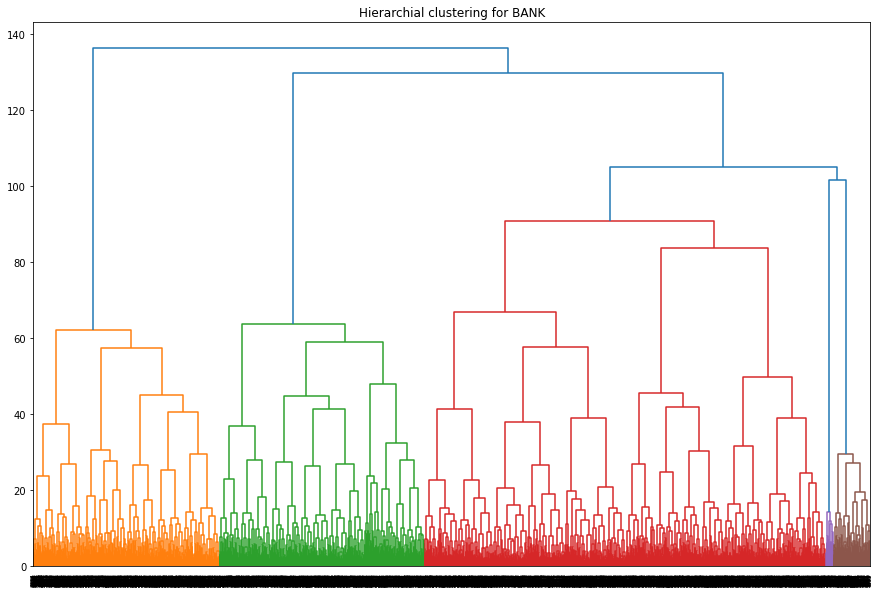

In [82]:
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for BANK')
plt.show()

## Статистические гипотезы и их проверка

In [85]:
bank_new_test = bank_new.fillna(-1)
bank_new_stay = bank_new_test.query('churn == 0 and balance != -1')
bank_new_go = bank_new_test.query('churn == 1 and balance != -1')

In [86]:
bank_new_1_test = bank_new_1.fillna(-1)
bank_new_2_test = bank_new_2.fillna(-1)
bank_multi_test = bank_new_multi.fillna(-1)

### Влияние дохода на количество продуктов банка

**Нулевая гипотеза:** клиенты с 1 продуктом банка имеют такой же доход, как и клиенты с двумя продуктами<br>
**Альтернативная гипотеза:** клиенты с 1 продуктом банка имеют отличный доход, от клиентов с двумя продуктами<br>

In [87]:
print('Средний доход клиента c 1 продуктом:', bank_new_1_test['estimated_salary'].mean())
print('Средний доход клиента с 2 продуктами:', bank_new_2_test['estimated_salary'].mean())
print('Средний доход клиента с несколькими продуктами:', bank_multi_test['estimated_salary'].mean())

Средний доход клиента c 1 продуктом: 99487.25685090481
Средний доход клиента с 2 продуктами: 100452.01282135077
Средний доход клиента с несколькими продуктами: 104400.1415030675


In [88]:
test_1_product = bank_new_1_test['estimated_salary']
test_2_product = bank_new_2_test['estimated_salary']
test_multi_product = bank_multi_test['estimated_salary']

alpha = 0.016 # критический уровень статистической значимости

results = st.ttest_ind(# проверка гипотезы 
    test_1_product, 
    test_2_product,
    equal_var = False) 

print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4106493940071987
Не получилось отвергнуть нулевую гипотезу


Средний доход клиентов с одним продуктом такой же, как у клиентов с 2 продуктами.

**Нулевая гипотеза:** клиенты с 2 продуктами банка имеют такой же доход, как и клиенты с несколькими продуктами<br>
**Альтернативная гипотеза:** клиенты с 2 продуктами банка имеют отличный доход, от клиентов с несколькими продуктами<br>

In [89]:
results = st.ttest_ind(# проверка гипотезы 
    test_multi_product, 
    test_2_product,
    equal_var = False) 

print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.21860891843672434
Не получилось отвергнуть нулевую гипотезу


Средний доход клиентов с двумя продуктами такой же, как у клиентов с несколькими продуктами.

**Нулевая гипотеза:** клиенты с 1 продуктом банка имеют такой же доход, как и клиенты с несколькими продуктами<br>
**Альтернативная гипотеза:** клиенты с 1 продуктом банка имеют отличный доход, от клиентов с несколькими продуктами<br>

In [90]:
results = st.ttest_ind(# проверка гипотезы
    test_multi_product, 
    test_1_product,
    equal_var = False)

print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

p-значение: 0.1245474203443419
Не получилось отвергнуть нулевую гипотезу


Средний доход клиентов с одним продуктом такой же, как у клиентов с несколькими продуктами.

### Влияние дохода на уход из банка

**Нулевая гипотеза:** доход клиентов, которые остаются в банке и которые уходят, одинаков<br>
**Альтернативная гипотеза:** доход клиентов, которые остаются в банке и которые уходят, разный<

In [91]:
print('Средний доход клиента, который остается:', bank_new_stay['estimated_salary'].mean())
print('Средний доход клиента, который уходит:', bank_new_go['estimated_salary'].mean())

Средний доход клиента, который остается: 100512.65443871234
Средний доход клиента, который уходит: 101362.74594014316


In [92]:
stay_test = bank_new_stay['estimated_salary']
go_test = bank_new_go['estimated_salary']

alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(# проверка гипотезы о равенстве средних двух независимых совокупностей
    stay_test, 
    go_test,
    equal_var = False) # т.к. дисперсии не равны

print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.6150083070259462
Не получилось отвергнуть нулевую гипотезу


Средний доход клиента, который остается в банке, аналогичен доходу клиента, который уйдет.

### Влияние пола на уход клиента из банка

**Нулевая гипотеза:** доля мужчин, которые остаются в банке, такая же, как и тех, которые уходят. <br>
**Альтернативная гипотеза:** доля мужчин, которые остаются в банке, отличается от тех, которые уходят.

In [93]:
print('Мужчина, который остается:', bank_new_stay['gender_М'].mean())
print('Мужчина, который уходит:', bank_new_go['gender_М'].mean())

Мужчина, который остается: 0.579034255055716
Мужчина, который уходит: 0.4476252439817827


In [94]:
stay_test = bank_new_stay['gender_М']
go_test = bank_new_go['gender_М']

alpha = 0.0125 # критический уровень статистической значимости

results = st.ttest_ind(# проверка гипотезы о равенстве средних двух независимых совокупностей
    stay_test, 
    go_test,
    equal_var = False) # т.к. дисперсии не равны

print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.996427957514376e-19
Отвергаем нулевую гипотезу


Доля мужчин, которые остаются в банке выше, чем доля мужчин, которые уходят.

**Нулевая гипотеза:** доля женщин, которые остаются в банке, такая же, как и тех, которые уходят. <br>
**Альтернативная гипотеза:** доля женщин, которые остаются в банке, отличается от тех, которые уходят.

In [95]:
print('Женщина, которая остается:', bank_new_stay['gender_Ж'].mean())
print('Женщина, которая уходит:', bank_new_go['gender_Ж'].mean())

Женщина, которая остается: 0.42096574494428396
Женщина, которая уходит: 0.5523747560182173


In [96]:
stay_test = bank_new_stay['gender_Ж']
go_test = bank_new_go['gender_Ж']

alpha = 0.0125 # критический уровень статистической значимости

results = st.ttest_ind(# проверка гипотезы о равенстве средних двух независимых совокупностей
    stay_test, 
    go_test,
    equal_var = False) # т.к. дисперсии не равны

print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.996427957514376e-19
Отвергаем нулевую гипотезу


Доля женщин, которые уходят из банка выше, чем доля женщин, которые остаются.

### Влияние возраста на уход клиента из банка

**Нулевая гипотеза:** возраст клиентов, которые остаются в банке, такой же, как и тех, которые уходят.<br>
**Альтернативная гипотеза:** возраст клиентов, которые остаются в банке, отличается от возраста тех клиентов, которые уходят.

In [97]:
print('Средний возраст клиента, который остается:', bank_new_stay['age'].mean())
print('Средний возраст клиента, который уходит:', bank_new_go['age'].mean())

Средний возраст клиента, который остается: 37.418695831613704
Средний возраст клиента, который уходит: 44.8067664281067


In [98]:
stay_test = bank_new_stay['age']
go_test = bank_new_go['age']

alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(# проверка гипотезы о равенстве средних двух независимых совокупностей
    stay_test, 
    go_test,
    equal_var = False) # т.к. дисперсии не равны

print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.0221492438129482e-129
Отвергаем нулевую гипотезу


Возраст клиента, который уходит из банка, выше, чем возраст клиента, который останется.

### Влияние количества продуктов на уход клиента из банка

**Нулевая гипотеза:** количество продуктов банка у клиента, который останется в банке, такой же, как и у клиента, который уйдет.<br>
**Альтернативная гипотеза:** количество продуктов банка у клиента, который останется в банке, отличается от количества продуктов клиента, который уйдет.

In [99]:
print('Среднее количество продуктов клиента, который остается:', bank_new_stay['products'].mean())
print('Среднее количество продуктов клиента, который уйдет:', bank_new_go['products'].mean())

Среднее количество продуктов клиента, который остается: 1.3607098638052002
Среднее количество продуктов клиента, который уйдет: 1.4658425504229018


In [100]:
stay_test = bank_new_stay['products']
go_test = bank_new_go['products']

alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(# проверка гипотезы о равенстве средних двух независимых совокупностей
    stay_test, 
    go_test,
    equal_var = False) # т.к. дисперсии не равны

print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.063422400138217e-06
Отвергаем нулевую гипотезу


Количество продуктов у клиента, который уходит из банка, выше, чем количество продуктов у клиента, который останется.

### Влияние скоринговой оценки на уход клиента из банка

**Нулевая гипотеза:** скоринговая оценка у клиента, который останется в банке, такой же, как и у клиента, который уйдет.<br>
**Альтернативная гипотеза:** скоринговая оценка у клиента, который останется в банке, отличается от количества продуктов клиента, который уйдет.

In [101]:
print('Средняя скоринговая оценка клиента, который остается:', bank_new_stay['score'].mean())
print('Средняя скоринговая оценка клиента, который уйдет:', bank_new_go['score'].mean())

Средняя скоринговая оценка клиента, который остается: 652.8202641353694
Средняя скоринговая оценка клиента, который уйдет: 645.83604424203


In [102]:
stay_test = bank_new_stay['score']
go_test = bank_new_go['score']

alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(# проверка гипотезы о равенстве средних двух независимых совокупностей
    stay_test, 
    go_test,
    equal_var = False) 
print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.016295202090946415
Отвергаем нулевую гипотезу


Скоринговая оценка клиента, который уйдет, будет ниже, чем скоринговая оценка клиента, который останется.

### Влияние текущей активности клиента на уход из банка

**Нулевая гипотеза:** текущая активность у клиента, который останется в банке, такая же, как и у клиента, который уйдет.<br>
**Альтернативная гипотеза:** текущая активность у клиента, который останется в банке, отличается от количества продуктов клиента, который уйдет.

In [103]:
print('Средняя активность клиента, который остается:', bank_new_stay['loyalty'].mean())
print('Средняя активность клиента, который уйдет:', bank_new_go['loyalty'].mean())

Средняя активность клиента, который остается: 0.5619067271976889
Средняя активность клиента, который уйдет: 0.36109303838646717


In [104]:
stay_test = bank_new_stay['loyalty']
go_test = bank_new_go['loyalty']

alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(# проверка гипотезы о равенстве средних двух независимых совокупностей
    stay_test, 
    go_test,
    equal_var = False) 
print('p-значение:', results.pvalue) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.859317777781856e-44
Отвергаем нулевую гипотезу


Средняя активность клиента, который уйдет, ниже, чем клиента, который останется.

## Выводы

### Изучение исходных данных
Таблица состоит из 12 столбцов и 10000 строк с разными типами значений.<br>
Есть количественные, булевы, вещественные, а также категориальные переменные.<br>
Явных дубликатов не обнаружено. Пропуски данных имеются только в строке Balance.<br>
Всего в данных содержится информация:
- о клиентах **3 городов**.<br>
- **Кредитный рейтинг** варьируется от 350 до 850 баллов.<br>
- **Возраст** клиентов от 18 до 92 лет.<br>
- Количество **обьектов в собственности** от 0 до 10.<br>
- Количество **банковских продуктов** у клиента может быть от 1 до 4.<br>
- **Кредитная карта** у клиента может быть, а может и не быть.<br>

### Предобработка данных
Переименуем и изменим написание ряда заголовков (сделаем написание строчными и через нижнее подчеркивание).<br>
Создадим еще один столбец и присвоим ему разную категорию в зависимости от зп (низкая, средняя и высокая).<br>
Применим метод get_dummies для преобразования города и пола в числовой код.<br>
Пропущены значения баланса для клиентов, которые проживают исключительно в Рыбинске и Ярославле. Возможно, техническая проблема, потому что другие закономерности неочевидны. <br>
Пропусков данных достаточно много, чтобы их удалить без последствий для dataset. Если заменить на 0, то сильно сдвинутся средние. Поэтому на текущий момент оставляем их без изменений.

### Исследовательский анализ данных (EDA)

#### Первичная оценка параметров данных
**city:**
- 25% клиентов проживают в Ростове Великом
- около 25% - в Рыбинске
- 50% клиентов живут в Ярославле

**gender:**
- около 45% клиентов женского пола
- около 55% - мужского пола

**score:**
- среднее значение кредитного рейтинга составляет 650, медиана - 652. Соответственно, значительных выбросов нет.
- минимум - 350, максимум - 850.

**age:**
- средний возраст клиента составляет почти 39 лет, а медианный - 37 лет. Также можно отметить отсутствие значительных выбросов.

**objects:**
- среднее и медианное количество объектов в собственности у клиента составляет 5 штук

**balance:**
- среднее значение баланса на счете у клиента составляет 119 827 единиц, медианное значение - 119 839 единиц. Отсутствие значительного количества выбросов. 
- минимум - 3769 единиц, максимум - 250 898 единиц.

**products:**
- у 50% клиентов всего один продукт.
- при этом среднее значение - 1,53 продукта. 
- всего 25% клиентов имеют 2 продукта банка и более, при этом максимальное число - 4 штуки.

**credit_cards:**
- у 70% клиентов есть кредитная карта.

**loyalty:**
- только 51,5% клиентов являются активными пользователями услуг банка.

**estimated_salary:**
- средняя и медианная зарплата клиентов примерно совпадает и составляет около 100 000. 
- 25% клиентов имеют зарплату 51 000 и менее, а другие 25% - почти 150 000 и более.

**churn:**
- уровень оттока клиентов составляет 20%.

#### Средние значения и распределение признаков в группе оставшихся клиентов и в группе ушедших
Исходя из средних значений числовых характеристик можно отметить следующие закономерности, которые мы наблюдаем у 'отточных' клиентов:
- более зрелые (средний возраст почти 45 лет против 37 лет у тех, кто остается)
- менее активно пользуются услугами банка (36% активных пользователей против 55% среди тех, кто остается)
- чаще проживают в городе Ростов Великий
- чаще женского пола

#### Матрица корреляций признаков

Матрица корреляций подтверждает ранее сделанные выводы: наибольшая положительная зависимость с оттоком у города Ростов Великий, полом (преимущественно женщины), возрастом. Отрицательная корреляция - лояльность (т.е. использование продуктов банка в текущий момент).

### Сегментация пользователей
#### Дерево принятия решений

Последовательность проверки клиентов на возможность уйти:

Возраст клиента меньше или равен 31 году.

Если да, то следующий вопрос касается количества продуктов: меньше 2 или больше 2.
Если два и меньше, то велика вероятность того, что клиент останется в банке.
Если больше двух, то такой клиент склонен уйти.

Если нет, то следующий вопрос касается текущей активности клиента.
Если активности нет, то велика вероятность того, что клиент уйдет.
Если активность есть, то велика вероятность того, что клиент останется.

#### Сегментация пользователей на основе количества используемых продуктов:

#### Предложение по группировке клиентов в зависимости от количества продуктов банка

Исходя из анализа характеристик каждой группы клиентов их можно условно разделить на 3 большие категории:
- c 1 продуктом банка
- c 2 продуктами банка
- с несколькими продуктами банка

#### Отличительные особенности каждой из групп

**Самая многочисленная группа - владельцы 1 продукта. Всего 5084 клиента.**<br>
**Средний уровень оттока клиентов (27,7%)** (по сравнению с двумя другими группами).<br>
<br>
- основном проживают в Ярославле (49%), Рыбинск и Ростов Великий распределяются примерно 50 на 50 (24% и 27% соответственно).
- распределение по полу идет в пользу мужчин (55%)
- средний возраст клиента составляет почти 40 лет, а медианный - 38 лет.
- 50% клиентов являются активными пользователями банковских услуг
- средняя и медианная зарплата клиентов примерно совпадает и составляет около 100 000.


**Вторая по численности группа - владельцы 2 продуктов. Всего 4590 клиентов.**<br>
**Минимальный уровень оттока клиентов (7,6%)** (по сравнению с двумя другими группами).<br>
<br>
- основном проживают в Ярославле (51%), Рыбинск и Ростов Великий распределяются примерно 50 на 50 (26% и 23% соответственно).
- распределение по полу идет в пользу мужчин (55%)
- самый "молодой" возраст среди всех 3 групп - средний 38 лет, а медианный - 36 лет.
- 53% клиентов являются активными пользователями услуг банка.
- средняя и медианная зарплата клиентов примерно совпадает и составляет около 100 000.


**Всего в группе с несколькими продуктами банка 326 клиентов**<br>
**Максимальный уровень оттока клиентов (86%!!!)** (по сравнению с двумя другими группами).
<br>
- основном проживают в Ярославле (41%), Ростове Великом (36%) и Рыбинске (22%). По сравнению с другими группами значительно ниже доля проживающих в Ярославле и значительно выше доля проживающих в Рыбинске.
- распределение по полу в пользу женщин (57%)
- самый "зрелый" возраст среди всех 3 групп - редний почти 44 года, а медианный - 43 года.
- 44% клиентов являются активными пользователями услуг банка (самый низкий!)
- максимальные средняя и медианная зарплата клиентов среди всех групп - около 104 000.

**Количество объектов в собственности, количество средств на балансе, средняя скоринговая оценка, доля кредитных карт совпадают у всех 3 групп.**

#### Отличия клиентов, которые остаются и которые уходят, по каждой группе

##### Отток клиентов с 1 продуктом
**Особенности при оттоке:**
- ниже скоринговая оценка (645 против 650)
- выше средний возраст (45 против 38)
- выше баланс на счету
- ниже лояльность (34% против 56%)
- выше зп
- чаще проживают в Ростове Великом, реже в Рыбинске и Ярославле
- чаще женщины (54%)
- чаще уходят клиенты с более высокой зарплатой (от 145000). Но влияние не кажется существенным.

##### Отток клиентов с 2 продуктами
**Особенности при оттоке:**
- ниже скоринговая оценка (653 против 644)
- выше средний возраст (45 против 37)
- меньше пользователей кредитных карт (68% против 71%)
- ниже лояльность (39% против 54%)
- чаще проживают в Ростове Великом, реже в Ярославле
- преимущественно женщины - 60%
- чаще уходят клиенты с более высокой зарплатой (от 145000). Но влияние не кажется существенным.

##### Отток клиентов с несколькими продуктами:

**Особенности при оттоке:**
- ниже скоринговая оценка (646 против 670)
- выше средний возраст (45 против 37)
- выше баланс по счету (120 155 против 118 423)
- больше количество продуктов (3,21 против 3)
- меньше пользователей кредитных карт (70% против 74%)
- ниже лояльность (40% против 60%)
- выше зарплата - 106 345 против 92 560
- чаще проживают в Ростове Великом, реже в Ярославле и Рыбинске
- преимущественно женщины - 60%

### Кластеризация клиентов
#### Кластеризация с использованием дендрограммы
Деление на 4 кластера
#### Кластеризация методом K-means
Методом подбора получилось, что один из самых высоких показателей siluette score при 7 кластерах.<br>
Уровень точности не очень высокий, соотвественно, лучше ориентироваться на признаки отточности, которые были в сегментации, а не на конкретные кластеры.<br>
Но в целом можем выделить тех клиентов, которых стимулировать не надо и подтвердить признаки оттока.<br>
<br>
**Не стимулируем:**
- Мужчины и женщины из Ярославля и Рыбинска с наличием активности в текущий период и менее 2 продуктами банка, возрастом около 31 год лет и меньше (согласно дереву принятия решений) и доходом около 100000, показывают самый низкий уровень оттока, стимулирование этих категорий клиентов пока нецелесообразно
- Из Ростова Великого с низким уровнем оттока - мужчины и женщины около 37 лет и меньше с доходом от 101 тысячи и менее 2 продуктов.
<br>

**Признаки оттока:**(подтверждение гипотез сегментации)
- низкий доход (ниже 98000),
- женский пол,
- возраст около 44-45 лет, 
- большое количество продуктов банка, 
- уровень лояльности меньше 40%,
- проживание в городе Ростов Великий

### Статистические гипотезы и их проверка
#### Влияние дохода на количество продуктов банка
Средний доход клиента c 1 продуктом: 99487.25685090481<br>
Средний доход клиента с 2 продуктами: 100452.01282135077<br>
Средний доход клиента с несколькими продуктами: 104400.1415030675<br>
<br>
**Нулевая гипотеза:** клиенты с 1 продуктом банка имеют такой же доход, как и клиенты с двумя продуктами<br>
**Альтернативная гипотеза:** клиенты с 1 продуктом банка имеют отличный доход, от клиентов с двумя продуктами<br>
p-значение: 0.4106493940071987<br>
Не получилось отвергнуть нулевую гипотезу: cредний доход клиентов с одним продуктом такой же, как у клиентов с 2 продуктами.<br>
<br>
**Нулевая гипотеза:** клиенты с 2 продуктами банка имеют такой же доход, как и клиенты с несколькими продуктами<br>
**Альтернативная гипотеза:** клиенты с 2 продуктами банка имеют отличный доход, от клиентов с несколькими продуктами<br>
p-значение: 0.21860891843672434<br>
Не получилось отвергнуть нулевую гипотезу: cредний доход клиентов с двумя продуктами такой же, как у клиентов с несколькими продуктами.<br>
<br>
**Нулевая гипотеза:** клиенты с 1 продуктом банка имеют такой же доход, как и клиенты с несколькими продуктами<br>
**Альтернативная гипотеза:** клиенты с 1 продуктом банка имеют отличный доход, от клиентов с несколькими продуктами<br>
p-значение: 0.1245474203443419<br>
Не получилось отвергнуть нулевую гипотезу: cредний доход клиентов с одним продуктом такой же, как у клиентов с несколькими продуктами.<br>
<br>
#### Влияние дохода на уход из банка
Средний доход клиента, который остается: 100512.65443871234<br>
Средний доход клиента, который уходит: 101362.74594014316<br>
**Нулевая гипотеза:** доход клиентов, которые остаются в банке и которые уходят, одинаков<br>
**Альтернативная гипотеза:** доход клиентов, которые остаются в банке и которые уходят, разный<br>
p-значение: 0.6150083070259462<br>
Не получилось отвергнуть нулевую гипотезу: cредний доход клиента, который остается в банке, аналогичен доходу клиента, который уйдет.<br>
<br>
#### Влияние пола на уход клиента из банка
Мужчина, который остается: 0.579034255055716<br>
Мужчина, который уходит: 0.4476252439817827<br>
**Нулевая гипотеза:** доля мужчин, которые остаются в банке, такая же, как и тех, которые уходят. <br>
**Альтернативная гипотеза:** доля мужчин, которые остаются в банке, отличается от тех, которые уходят.<br>
p-значение: 2.996427957514376e-19<br>
Отвергаем нулевую гипотезу: доля мужчин, которые остаются в банке выше, чем доля мужчин, которые уходят.<br>
<br>
Женщина, которая остается: 0.42096574494428396<br>
Женщина, которая уходит: 0.5523747560182173<br>
**Нулевая гипотеза:** доля женщин, которые остаются в банке, такая же, как и тех, которые уходят. <br>
**Альтернативная гипотеза:** доля женщин, которые остаются в банке, отличается от тех, которые уходят.<br>
p-значение: 2.996427957514376e-19<br>
Отвергаем нулевую гипотезу: доля женщин, которые уходят из банка выше, чем доля женщин, которые остаются<br>

#### Влияние возраста на уход клиента из банка
Средний возраст клиента, который остается: 37.418695831613704<br>
Средний возраст клиента, который уходит: 44.8067664281067<br>
**Нулевая гипотеза:** возраст клиентов, которые остаются в банке, такой же, как и тех, которые уходят.<br>
**Альтернативная гипотеза:** возраст клиентов, которые остаются в банке, отличается от возраста тех клиентов, которые уходят.<br>
p-значение: 2.0221492438129482e-129<br>
Отвергаем нулевую гипотезу: возраст клиента, который уходит из банка, выше, чем возраст клиента, который останется.

#### Влияние количества продуктов на уход клиента из банка
Среднее количество продуктов клиента, который остается: 1.3607098638052002<br>
Среднее количество продуктов клиента, который уйдет: 1.4658425504229018<br>
**Нулевая гипотеза:** количество продуктов банка у клиента, который останется в банке, такой же, как и у клиента, который уйдет.<br>
**Альтернативная гипотеза:** количество продуктов банка у клиента, который останется в банке, отличается от количества продуктов клиента, который уйдет.<br>
p-значение: 1.063422400138217e-06<br>
Отвергаем нулевую гипотезу: количество продуктов у клиента, который уходит из банка, выше, чем количество продуктов у клиента, который останется.<br>

#### Влияние скоринговой оценки на уход клиента из банка
Средняя скоринговая оценка клиента, который остается: 652.8202641353694<br>
Среднее скоринговая оценка клиента, который уйдет: 645.83604424203<br>
**Нулевая гипотеза:** скоринговая оценка у клиента, который останется в банке, такой же, как и у клиента, который уйдет.<br>
**Альтернативная гипотеза:** скоринговая оценка у клиента, который останется в банке, отличается от количества продуктов клиента, который уйдет.<br>
p-значение: 0.016295202090946415<br>
Отвергаем нулевую гипотезу: скоринговая оценка клиента, который уйдет, будет ниже, чем скоринговая оценка клиента, который останется.

#### Влияние текущей активности клиента на уход из банка
Средняя активность клиента, который остается: 0.5619067271976889<br>
Средняя активность клиента, который уйдет: 0.36109303838646717<br>
**Нулевая гипотеза:** текущая активность у клиента, который останется в банке, такая же, как и у клиента, который уйдет.<br>
**Альтернативная гипотеза:** текущая активность у клиента, который останется в банке, отличается от количества продуктов клиента, который уйдет.<br>
p-значение: 5.859317777781856e-44<br>
Отвергаем нулевую гипотезу: средняя активность клиента, который уйдет, ниже, чем клиента, который останется.<br>

## Основные предложения по маркетинговой активности

**Основные положения:**<br>

**Целевая аудитория 1**<br>
- 1 продукт банка
- возраст 38-65 лет
- 0 уровень активности

**Целевая аудитория 2**<br>
- 3 и более продуктов банка

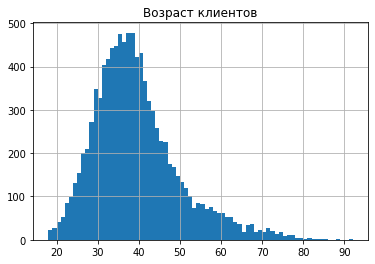

In [105]:
bank.age.hist(bins=range(18,93)).set(title="Возраст клиентов");

**Для ЦА1:**<br>
- предлагать оформить второй продукт (особенно кредитную карту, если еще нет у клиента)
- у тех, у кого есть кредитная карта, - стимулировать ее использование: подарки за определенное количество транзакций/сумму, кэш-бек
- посмотреть у активных зрелых клиентов, какие у них есть особенности использования карты, и предложить акции на этой основе зрелым, но неактивным.

**Для ЦА2:**
- если большое количество кредитов и клиент выразил желание уйти, то предложить рефинансирование
- если высокий доход у клиента и мало кредитных продуктов, то предложить интересные условия по вкладам